In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
import ruptures as rpt
from scipy.signal import find_peaks
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA as SKPCA
import math
import os


## Where to change the patient file path

In [8]:
sub = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_06_08_2023_LSTN_subject7\Processed DLC\csv folder')

## Patient Specific Items

In [4]:
# use this if one trial is incomplete or does not work well
# only put the depth with no front or side
skip_trails = []

## Functions

In [5]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

In [29]:
def hand_PS_mov(df, t, slope_threshold=0.05, window=5):
    '''reports the peaks and the troughs'''

    if not hasattr(t, '__iter__') or len(t) < 2:
        print(f"Invalid 't' input: {t}")
        return np.array([], dtype=int), np.array([], dtype=int), np.array([])


    def gauss_smooth_uniform(yin, dt, gkern_std):
        sigma_samples = gkern_std / dt
        yout = gaussian_filter1d(yin, sigma=sigma_samples, mode='reflect')
        return yout

    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    fy = df['fTip1'][start_idx:end_idx].values 
    py = df['PalmBase'][start_idx:end_idx].values
    t_np = np.arange(start_idx, end_idx)

    euc_dis_bef = fy - py
    euc_dis = gauss_smooth_uniform(euc_dis_bef, 0.01, 0.05)

    peaks, _ = find_peaks(euc_dis, distance=None, prominence=3, width=3)
    troughs, _ = find_peaks(-euc_dis, distance=None, prominence=5, width=5)

    print(f"Raw peaks: {peaks}, dtype: {peaks.dtype}")
    print(f"Raw troughs: {troughs}, dtype: {troughs.dtype}")

    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    # Cast explicitly to int
    peaks = np.array(peaks).astype(int)
    troughs = np.array(troughs).astype(int)

    try:
        t_peak = t_np[peaks]
        t_trough = t_np[troughs]
    except Exception as e:
        print(f"Error indexing t_np with peaks/troughs: {e}")
        t_peak = np.array([], dtype=int)
        t_trough = np.array([], dtype=int)

    return t_peak, t_trough, euc_dis


In [30]:
def arm_EF_mov(df, t):
    '''reports the peaks and troughs'''

    def gauss_smooth_uniform(yin, dt, gkern_std):
        """
        Smooth 'yin' using a Gaussian filter via convolution.
        
        Parameters:
            yin : numpy array of signal values
            dt : time step between samples (e.g., 0.001 for 1kHz)
            gkern_std : Gaussian kernel std in time units (e.g., 0.05s)
        
        """
        # Convert gkern_std from time units to number of samples
        sigma_samples = gkern_std / dt
        yout = gaussian_filter1d(yin, sigma=sigma_samples, mode='reflect')
        return yout
    
    # point of interest
    fTip3 = df['fTip3']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y_unsmooth = fTip3[start_idx:end_idx].values
    y_unsmooth = np.array(y_unsmooth).flatten().astype(np.float64)
    y = gauss_smooth_uniform(y_unsmooth, 0.01, 0.05)
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=300, threshold=None, distance=80, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=80, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, y

In [31]:
def hand_OC_mov(df, t, slope_threshold=0.05, window=5):
    '''
    Reports the peaks and troughs from the Euclidean distance after filtering flat regions.
    '''

    def gauss_smooth_uniform(yin, dt, gkern_std):
        """
        Smooth 'yin' using a Gaussian filter via convolution.
        
        Parameters:
            yin : numpy array of signal values
            dt : time step between samples (e.g., 0.001 for 1kHz)
            gkern_std : Gaussian kernel std in time units (e.g., 0.05s)
        
        """
        # Convert gkern_std from time units to number of samples
        sigma_samples = gkern_std / dt
        yout = gaussian_filter1d(yin, sigma=sigma_samples, mode='reflect')
        return yout

    # --- Signal extraction ---
    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    fy = df['fTip3.1'][start_idx:end_idx].values 
    py = df['PalmBase.1'][start_idx:end_idx].values
    t_np = np.arange(start_idx, end_idx)

    # Element-wise subtraction: col1 - col2
    euc_dis_bef = fy - py
    euc_dis = gauss_smooth_uniform(euc_dis_bef, 0.01, 0.05)

    # --- Peak & Trough Detection ---
    peaks, _ = find_peaks(euc_dis, height=None, distance=30, prominence=5, width=5)
    troughs, _ = find_peaks(-euc_dis, distance=None, prominence=5, width=5)

    # --- Boundary Filter ---
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    # --- Time Mapping ---
    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, euc_dis


In [32]:
def compute_peaks_troughs(row):
    base = row['dataset']  # like 'b1', 't2', etc.
    view = row['view']     # 'front' or 'side'

    if view == 'side':
        return None  # Skip side views early exit

    try:
        dff = dataframes.get(base + 'f')
        hand_OC_peaks, hand_OC_troughs, hand_OC_euclidean = hand_OC_mov(dff, row['hand_OC'])
        hand_PS_peaks, hand_PS_troughs, hand_PS_euclidean = hand_PS_mov(dff, row['hand_PS'])
        arm_EF_peaks, arm_EF_troughs, arm_EF_data = arm_EF_mov(dff, row['arm_EF'])

        # Ensure integer arrays for indexing later
        hand_OC_peaks = np.array(hand_OC_peaks, dtype=int)
        hand_OC_troughs = np.array(hand_OC_troughs, dtype=int)
        hand_PS_peaks = np.array(hand_PS_peaks, dtype=int)
        hand_PS_troughs = np.array(hand_PS_troughs, dtype=int)
        arm_EF_peaks = np.array(arm_EF_peaks, dtype=int)
        arm_EF_troughs = np.array(arm_EF_troughs, dtype=int)

        # Return Series with all front-view metrics
        return pd.Series({
            'hand_OC_peaks': hand_OC_peaks,
            'hand_OC_troughs': hand_OC_troughs,
            'hand_OC_euclidean_dis': hand_OC_euclidean,
            'hand_PS_peaks': hand_PS_peaks,
            'hand_PS_troughs': hand_PS_troughs,
            'hand_PS_euclidean_dis': hand_PS_euclidean,
            'arm_EF_peaks': arm_EF_peaks,
            'arm_EF_troughs': arm_EF_troughs,
            'arm_EF_data': arm_EF_data
        })

    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        # Return a Series filled with None for all expected outputs
        return pd.Series({
            'hand_OC_peaks': None, 'hand_OC_troughs': None, 'hand_OC_euclidean_dis': None,
            'hand_PS_peaks': None, 'hand_PS_troughs': None,
            'arm_EF_peaks': None, 'arm_EF_troughs': None
        })

In [33]:
def run_PCA(X, indices, view, mov, n_components=None):
    '''Calculates PCA for one camera view and one probe position'''

    # 1. Takes into consideration if there are indices or not (helpful for when looking at specific movement)
    if indices is not None:
        X_subset = X.iloc[indices[0]:indices[1]+1]
    else:
        X_subset = X

    # 2. Drop columns containing '.2' --> dropping likelihood rows
    df = X_subset.loc[:, ~X_subset.columns.str.contains(r'\.2')]

    # 3. Remove constant columns --> gets rid of runs that were unsuccessful 
    stds = df.std(axis=0)
    df = df.loc[:, stds != 0]

    # 4. Standardize the data --> standardize mean to 0 and std to 1 (suggested from geeks for geeks)
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df)

    # 5. Apply PCA
    pca = SKPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_standardized)

    # 6. Output
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance = pca.explained_variance_
    pca_components = pca.components_ # direction (vectors) the define the PCs in the original feature space pca_components[0] are the scores in regards to PCA1



    return X_pca, explained_variance_ratio, explained_variance, pca_components


def trim_initial_zeros(df):
    """
    Trims the DataFrame by removing rows at the beginning where ANY column is 0.
    Once all columns have non-zero values, keeps everything from that row on.
    Necessary because rows were set to 0 when filtering likelihood
    """
    mask = (df != 0).any(axis=1)
    first_valid_index = mask.idxmax()  # first row where any column is non-zero
    return df.loc[first_valid_index:].reset_index(drop=True)

In [12]:
def average_close_indices(index_list, threshold=100):
    if not index_list:
        return []

    averaged = []
    current_group = [index_list[0]]

    for i in range(1, len(index_list)):
        if abs(index_list[i] - sum(current_group)/len(current_group)) <= threshold:
            current_group.append(index_list[i])
        else:
            # Commit the average of the current group
            averaged.append(int(sum(current_group)/len(current_group)))
            # Start new group
            current_group = [index_list[i]]

    # Don't forget the last group
    averaged.append(int(sum(current_group)/len(current_group)))
    return averaged


In [13]:
def gauss_smooth_uniform(yin, dt, gkern_std):
    """
    Smooth 'yin' using a Gaussian filter via convolution.
    
    Parameters:
        yin : numpy array of signal values
        dt : time step between samples (e.g., 0.001 for 1kHz)
        gkern_std : Gaussian kernel std in time units (e.g., 0.05s)
    
    """
    # Convert gkern_std from time units to number of samples
    sigma_samples = gkern_std / dt
    yout = gaussian_filter1d(yin, sigma=sigma_samples, mode='reflect')
    return yout


## Creates dataframes for each depth

In [9]:
# List of base labels (subject-depth identifiers)
base_labels = ['b1', 'b2', 'b3', 'c1', 'c2', 'c3', 't1', 't2', 't3']

# Place to store all the DataFrames
dataframes = {}

files = list(sub.iterdir())

# First, filter out LC2 files
valid_files = [file for file in files if 'LC2' not in file.name]

# Iterate through all files and match them
for file in valid_files:
    filename = file.name.lower()

    # Find which base label (b1, b2, etc.) is in the filename
    base_label = None
    for base in base_labels:
        if base in filename:
            base_label = base
            break

    if base_label is None:
        print(f"Skipping file (no base label match): {filename}")
        continue  # Skip files without a base label match

    # Determine if it's front or side view
    if 'front' in filename:
        suffix = 'f'
    elif 'side' in filename:
        suffix = 's'
    else:
        print(f"Skipping file (no view info): {filename}")
        continue  # Skip files without view info

    # Construct full label (e.g., 'b1f', 'c2s')
    label = base_label + suffix

    # Load and store in dictionary
    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")



     bodyparts            PalmBase          PalmBase.1          PalmBase.2  \
0       coords                   x                   y          likelihood   
1            0  252.36361694335938  434.53948974609375  0.9988238215446472   
2            1  252.68418884277344   433.8633728027344   0.998389720916748   
3            2   252.5994873046875   433.7718505859375  0.9988269209861755   
4            3   252.4776153564453  433.73077392578125  0.9988343119621277   
...        ...                 ...                 ...                 ...   
3511      3510  263.21392822265625   458.5610656738281  0.9996635913848877   
3512      3511   262.9482727050781   458.4751892089844  0.9996614456176758   
3513      3512   263.0736389160156  458.99481201171875  0.9995790123939514   
3514      3513   263.2882080078125   458.1141357421875  0.9995368719100952   
3515      3514   263.5245361328125     458.66943359375   0.999607264995575   

                    MCP1              MCP1.1              MCP1.

## Runs PCA and ruptures on PC1 and PC2 to create df_indices

For b1f the variance for PC1 is 0.6442 and PC2 is 0.2525


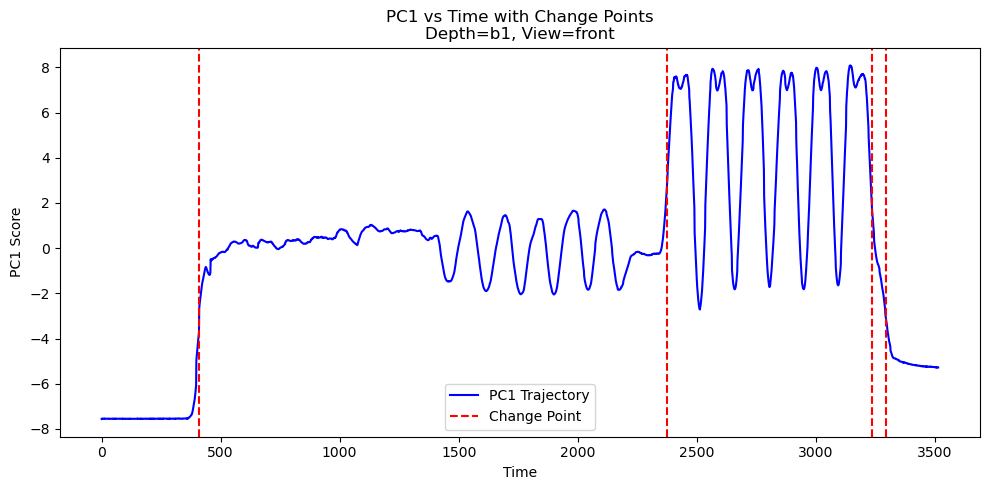

Change points (frame indices) for b1 front: [410, 2375, 3235, 3295, 3515]
For c1f the variance for PC1 is 0.6815 and PC2 is 0.2083


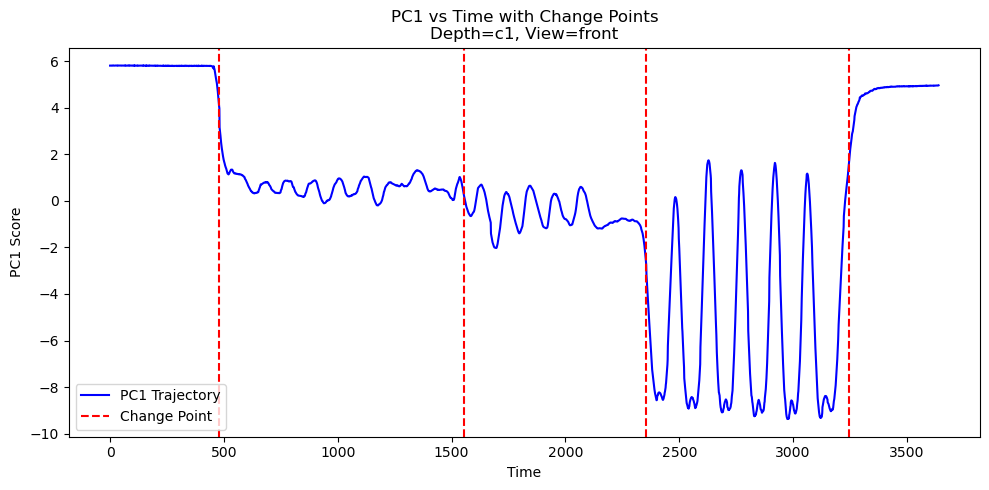

Change points (frame indices) for c1 front: [480, 1555, 2355, 3245, 3640]
For c2f the variance for PC1 is 0.6340 and PC2 is 0.2865


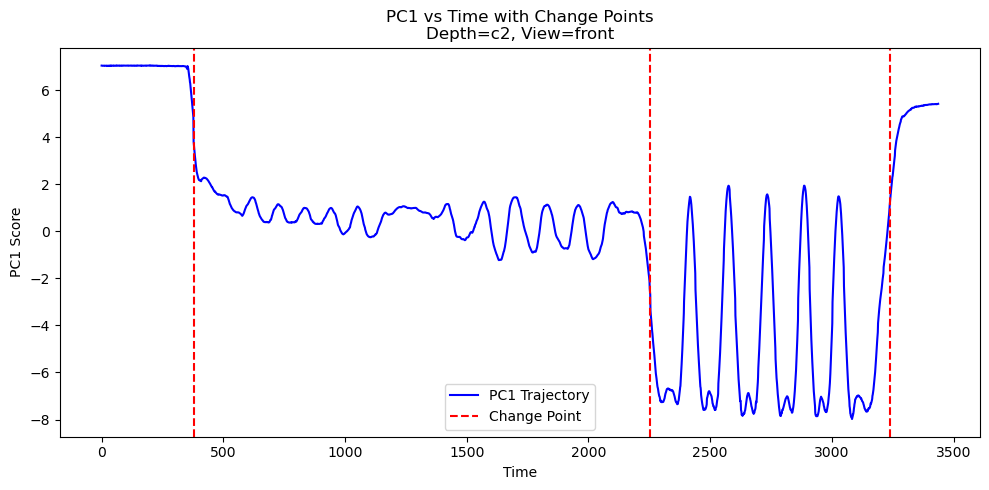

Change points (frame indices) for c2 front: [380, 2255, 3240, 3438]
For c3f the variance for PC1 is 0.6146 and PC2 is 0.2774


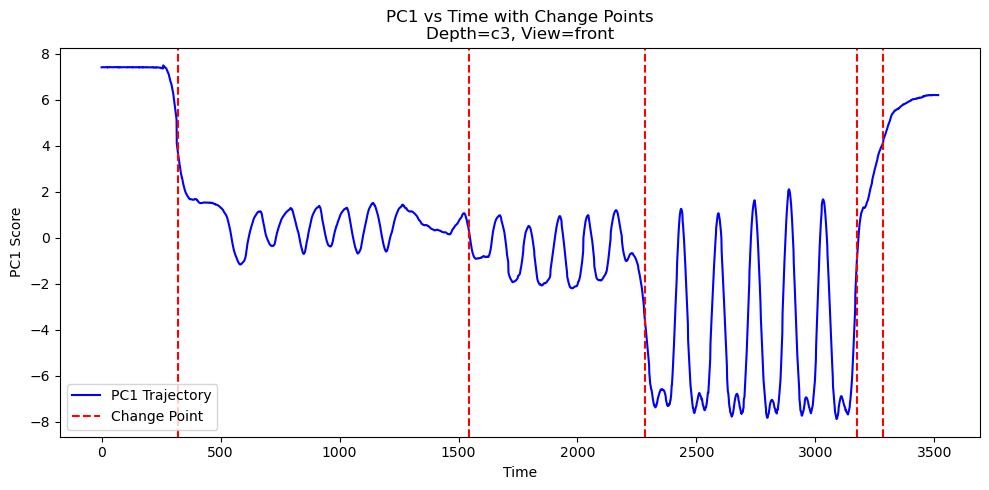

Change points (frame indices) for c3 front: [320, 1545, 2285, 3175, 3285, 3517]
For t3f the variance for PC1 is 0.5796 and PC2 is 0.2706


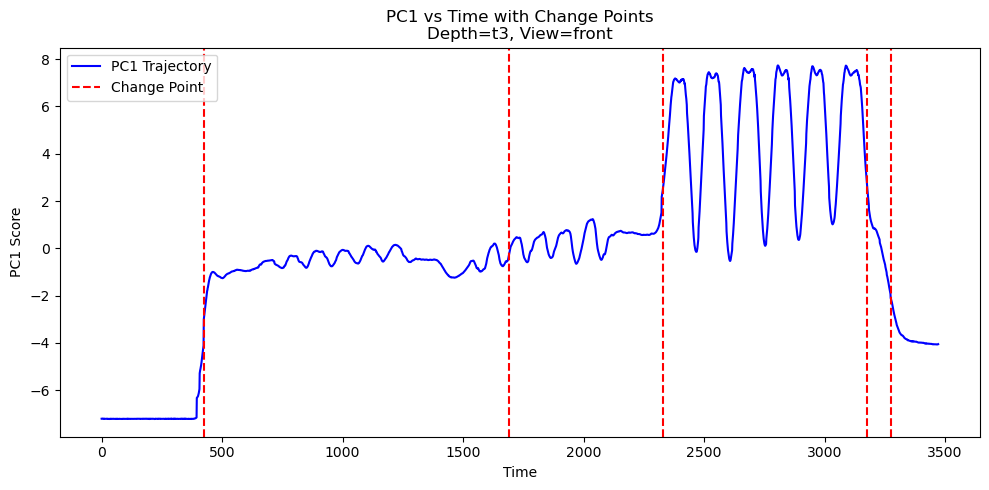

Change points (frame indices) for t3 front: [425, 1690, 2330, 3175, 3275, 3472]
  depth   view component feature_1  weight_1 feature_2  weight_2   feature_3  \
0    b1  front       PC1      MCP5  0.225705   fTip5.1 -0.225112  PalmBase.1   
1    c1  front       PC1    MCP5.1  0.221498   fTip5.1  0.217318  PalmBase.1   
2    c2  front       PC1    MCP5.1  0.221327   fTip5.1  0.212959  PalmBase.1   
3    c3  front       PC1    MCP5.1  0.223981   fTip5.1  0.217790  PalmBase.1   
4    t3  front       PC1      MCP5  0.247257  PalmBase  0.244527     fTip5.1   

   weight_3   feature_4  weight_4 feature_5  weight_5  
0 -0.223219      MCP4.1 -0.222436   fTip4.1 -0.218517  
1  0.216170      MCP4.1  0.214560  PalmBase -0.212837  
2  0.211758      MCP4.1  0.210760     fTip1 -0.209062  
3  0.216333      MCP4.1  0.215206  PalmBase -0.210491  
4 -0.221733  MidForeArm  0.220396    MCP4.1 -0.216332  
  depth   view component     feature_1  weight_1 feature_2  weight_2  \
0    b1  front       PC2  MidFo

In [28]:
# Initialize empty lists before loop
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []
top5_pc2_rows = []

# 
results_list = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

for base in dataframes:
    mov = 'all'  # example movement label
    df = dataframes[base]

    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    print(f'For {base} the variance for PC1 is {explained_variance_ratio[0]:.4f} and PC2 is {explained_variance_ratio[1]:.4f}')
    

    # X_pca shape: (n_samples, 2)
    pc1_scores = X_pca[:, 0]
    pc2_scores = X_pca[:, 1]
    t = np.arange(len(pc1_scores))

    # Now stack them for ruptures
    signal = np.column_stack((pc1_scores, pc2_scores))

    # Run ruptures (as you already do)
    algo = rpt.Pelt(model='rbf').fit(signal)
    change_points = algo.predict(pen=penalty_value)

    # Plot 3D trajectory with change points
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    
    plt.figure(figsize=(10, 5))

    # Plot PC1 scores over time
    plt.plot(t, pc1_scores, color='blue', label='PC1 Trajectory')

    # Mark change points with vertical dashed lines
    for cp in change_points[:-1]:  # Skip last point if it’s at the end
        plt.axvline(x=cp, color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")

    plt.xlabel('Time')
    plt.ylabel('PC1 Score')
    plt.title(f'PC1 vs Time with Change Points\nDepth={depth}, View={view_type}')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Print results
    print(f"Change points (frame indices) for {depth} {view_type}: {change_points}")

    # Create a dictionary for storing change point results
    dic_indices = {
        "depth": depth,
        "view": view_type,
        "component": "indices"
    }

    # Save the top features and their change points
    dic_indices["change_points"] = change_points

    # Assuming you're collecting multiple such dictionaries into a list
    results_list.append(dic_indices)

    

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create dicts for PC1 and PC2 rows
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1",
        "values" : pc1_scores
    }
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2",
        "values" : pc2_scores
    }

    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append rows to respective lists
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    # Save explained variance for PC1 and PC2
    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })

    # Top 5 contributors for PC1
    feature_contributions_pc1 = list(zip(final_cols, pc1))
    feature_contributions_pc1.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc1 = feature_contributions_pc1[:5]

    top5_pc1_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5_pc1):
        top5_pc1_dict[f"feature_{idx+1}"] = feat
        top5_pc1_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_pc1_dict)

    # Top 5 contributors for PC2
    feature_contributions_pc2 = list(zip(final_cols, pc2))
    feature_contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = feature_contributions_pc2[:5]

    top5_pc2_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_pc2_dict[f"feature_{idx+1}"] = feat
        top5_pc2_dict[f"weight_{idx+1}"] = weight
    top5_pc2_rows.append(top5_pc2_dict)

# Create DataFrames after loop
pca1_df = pd.DataFrame(pca1_rows)
pca2_df = pd.DataFrame(pca2_rows)
explained_df = pd.DataFrame(explained_var_rows)
top5_pc1_df = pd.DataFrame(top5_pc1_rows)
top5_pc2_df = pd.DataFrame(top5_pc2_rows)

print(top5_pc1_df)
print(top5_pc2_df)


In [34]:
top5_pc1_df

,depth,view,component,feature_1,weight_1,feature_2,weight_2,feature_3,weight_3,feature_4,weight_4,feature_5,weight_5
0,b1,front,PC1,MCP5,0.225705,fTip5.1,-0.225112,PalmBase.1,-0.223219,MCP4.1,-0.222436,fTip4.1,-0.218517
1,c1,front,PC1,MCP5.1,0.221498,fTip5.1,0.217318,PalmBase.1,0.216170,MCP4.1,0.214560,PalmBase,-0.212837
2,c2,front,PC1,MCP5.1,0.221327,fTip5.1,0.212959,PalmBase.1,0.211758,MCP4.1,0.210760,fTip1,-0.209062
3,c3,front,PC1,MCP5.1,0.223981,fTip5.1,0.217790,PalmBase.1,0.216333,MCP4.1,0.215206,PalmBase,-0.210491
4,t3,front,PC1,MCP5,0.247257,PalmBase,0.244527,fTip5.1,-0.221733,MidForeArm,0.220396,MCP4.1,-0.216332


In [35]:
pca1_df

,depth,view,component,values,PalmBase,PalmBase.1,MCP1,MCP1.1,MCP2,MCP2.1,...,fTip3,fTip3.1,fTip4,fTip4.1,fTip5,fTip5.1,MidForeArm,MidForeArm.1,Elbow,Elbow.1
0,b1,front,PC1,"[-7.558006725161321, -7.547622331763729, -7.55...",0.203160,-0.223219,0.202649,-0.201322,0.200595,-0.208609,...,0.189781,-0.212434,0.189787,-0.218517,0.188017,-0.225112,0.201870,0.118918,0.164057,0.150883
1,c1,front,PC1,"[5.80751981356834, 5.809814251277348, 5.808052...",-0.212837,0.216170,-0.208493,0.198592,-0.208563,0.201016,...,-0.199311,0.204433,-0.199235,0.209611,-0.199232,0.217318,-0.176187,-0.077887,-0.109094,-0.101592
2,c2,front,PC1,"[7.040466521882552, 7.038292327945735, 7.03148...",-0.208083,0.211758,-0.206355,0.185945,-0.207118,0.192441,...,-0.203847,0.195107,-0.205311,0.202727,-0.205534,0.212959,-0.201038,-0.106101,-0.137492,-0.132992
3,c3,front,PC1,"[7.413895726090499, 7.41831985214348, 7.419768...",-0.210491,0.216333,-0.205637,0.192777,-0.206582,0.198207,...,-0.200210,0.201542,-0.201479,0.208600,-0.201576,0.217790,-0.200518,-0.086231,-0.112325,-0.106598
4,t3,front,PC1,"[-7.214786642094398, -7.213566354633988, -7.21...",0.244527,0.073210,0.210167,-0.199827,0.208235,-0.199184,...,0.201228,-0.204817,0.201102,-0.212225,0.200604,-0.221733,0.220396,0.131532,0.144608,0.140042


## Visualize indices df

In [24]:
df_indices = pd.DataFrame(results_list)

df_indices 

,depth,view,component,change_points
0,b1,front,indices,"[410, 2375, 3235, 3295, 3515]"
1,c1,front,indices,"[480, 1555, 2355, 3245, 3640]"
2,c2,front,indices,"[380, 2255, 3240, 3438]"
3,c3,front,indices,"[320, 1545, 2285, 3175, 3285, 3517]"
4,t3,front,indices,"[425, 1690, 2330, 3175, 3275, 3472]"


## Averaging close datapoints

In [59]:
# Create an empty list to hold averaged points for each row
averaged_points_list = []

# Loop through each row in the DataFrame
for _, row in df_indices.iterrows():
    change_points = row['change_points']
    averaged_points = average_close_indices(change_points, threshold=115)
    averaged_points_list.append(averaged_points)

# Assign the results as a new column in the DataFrame
df_indices['averaged_points'] = averaged_points_list

## Creating movement df for armEF

In [60]:
df_movements = pd.DataFrame(columns=['dataset', 'view', 'arm_EF', 'hand_OC', 'hand_PS'])

for _, row in df_indices.iterrows():
    all_indices = row['averaged_points']
    movement = 'arm_EF'

    # skipping trials if they are incomplete (defined above)
    if row['depth'] in skip_trails:
        continue

    if len(all_indices) == 1:
        continue

    dif = all_indices[-2] - all_indices[-1]
    print(f'the difference is {dif}')

    if np.abs(all_indices[-2] - all_indices[-1]) < 500:
        if len(all_indices) >= 3:
            start = all_indices[-3]
            end = all_indices[-2]
        else: 
            start = all_indices[-2]
            end = all_indices[-1]
    else:
        start = all_indices[-2]
        end = all_indices[-1]
        

    df_movements = pd.concat([
    df_movements,
    pd.DataFrame([{
        'dataset': row['depth'],        # <- use `row` to access data from df_indices
        'view': row['view'],
        'arm_EF': (start, end),
        'hand_OC': (0,0),
        'hand_PS': (0,0)
    }])
], ignore_index=True)

print(df_movements)

the difference is -250
the difference is -395
the difference is -198
the difference is -287
the difference is -247
  dataset   view        arm_EF hand_OC hand_PS
0      b1  front  (2375, 3265)  (0, 0)  (0, 0)
1      c1  front  (2355, 3245)  (0, 0)  (0, 0)
2      c2  front  (2255, 3240)  (0, 0)  (0, 0)
3      c3  front  (2285, 3230)  (0, 0)  (0, 0)
4      t3  front  (2330, 3225)  (0, 0)  (0, 0)


## Visualizing armEF segmentation

2375
3265
RangeIndex(start=0, stop=5, step=1)
2355
3245
RangeIndex(start=0, stop=5, step=1)
2255
3240
RangeIndex(start=0, stop=5, step=1)
2285
3230
RangeIndex(start=0, stop=5, step=1)
2330
3225
RangeIndex(start=0, stop=5, step=1)


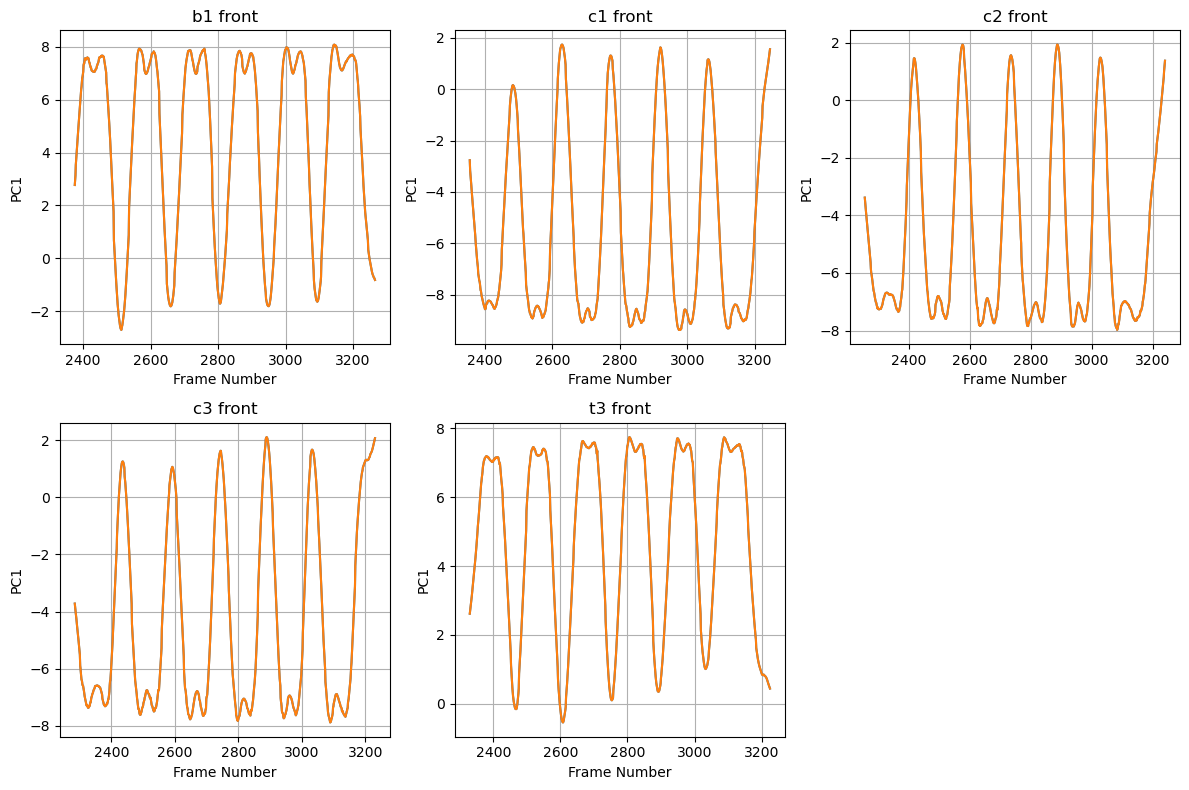

In [61]:
import matplotlib.pyplot as plt
import math

# Filter out rows where depth is 't1'
filtered_movements = df_movements[df_movements['dataset'] != 't1']
n = len(filtered_movements)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=False)
axs = axs.flatten()

for idx, (i, row) in enumerate(filtered_movements.iterrows()):
    depth = row['dataset']
    view_type = row['view']
    start, end = row['arm_EF']  

    print(start)
    print(end)
    print(pca1_df.index)

    some_row = idx
    values_list = pca1_df.loc[some_row, 'values']  # single list or array
    segment = values_list[start:end+1]
    t = np.arange(start, end+1)


    ax = axs[idx]
    ax.plot(t, segment)
    ax.plot(t, segment, label='PC1 Segment')
    ax.set_title(f"{depth} {view_type}")
    ax.set_ylabel('PC1')
    ax.set_xlabel('Frame Number')
    ax.grid(True)

# Hide any unused subplots
for i in range(n, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


## Run PCA on only handOC and handPS time 

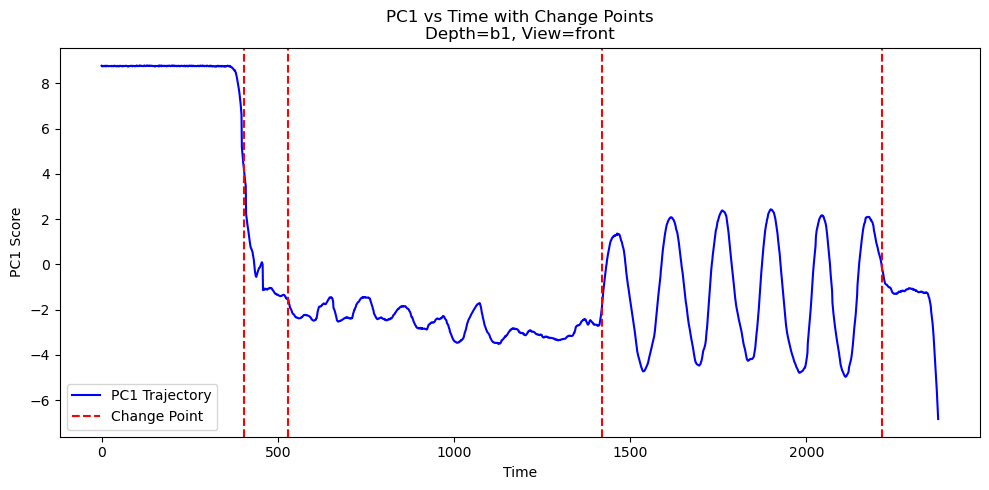

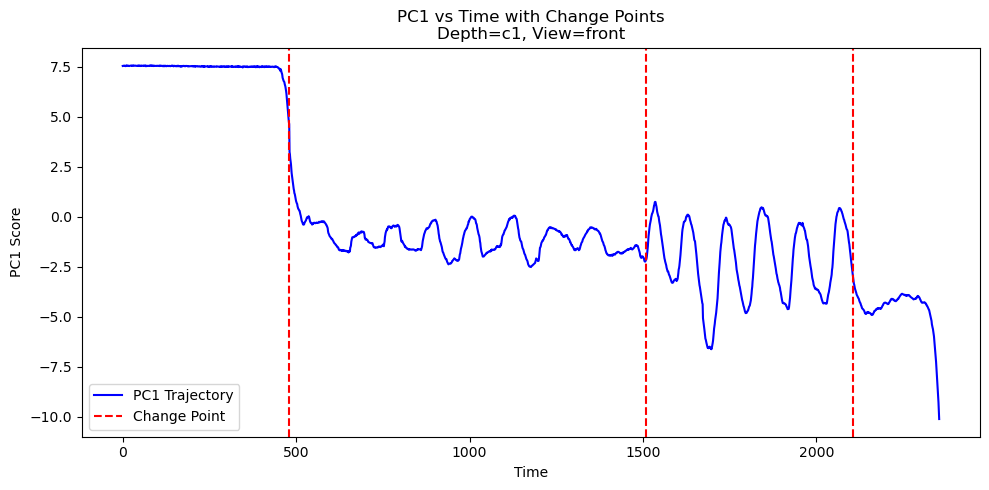

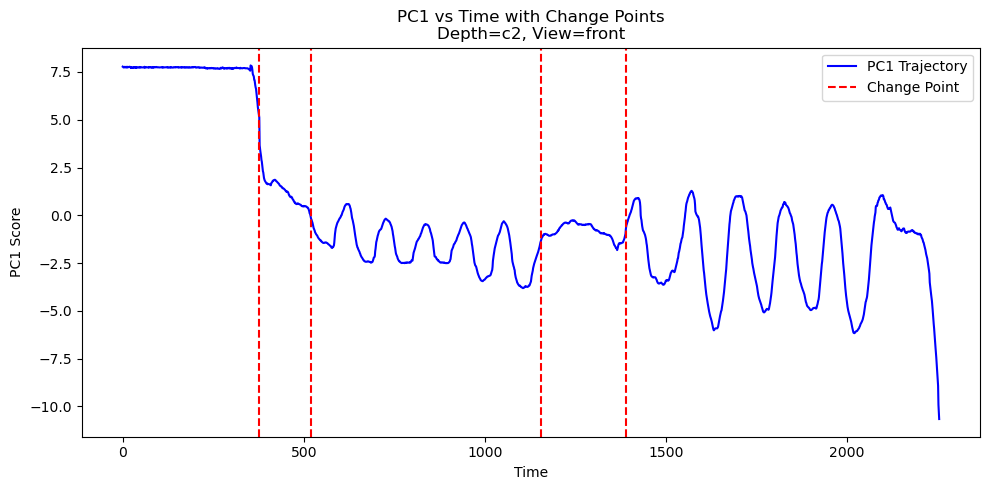

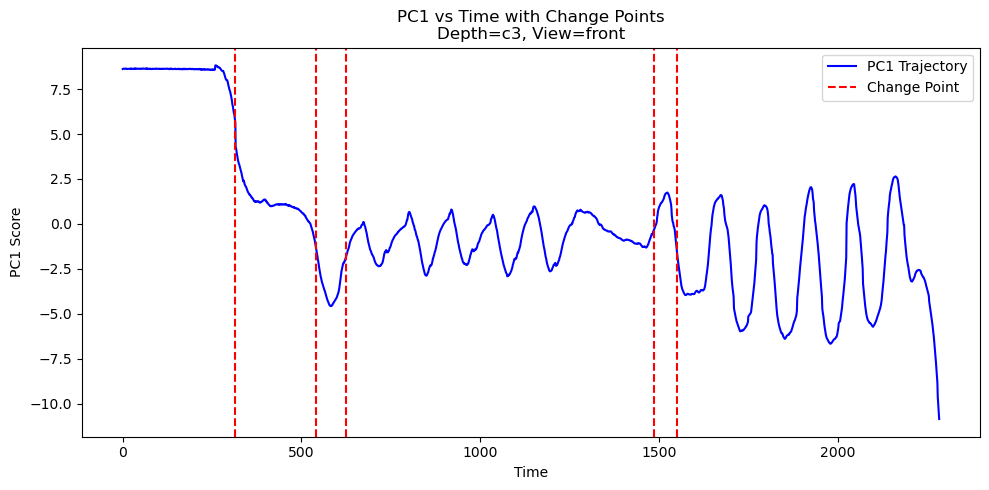

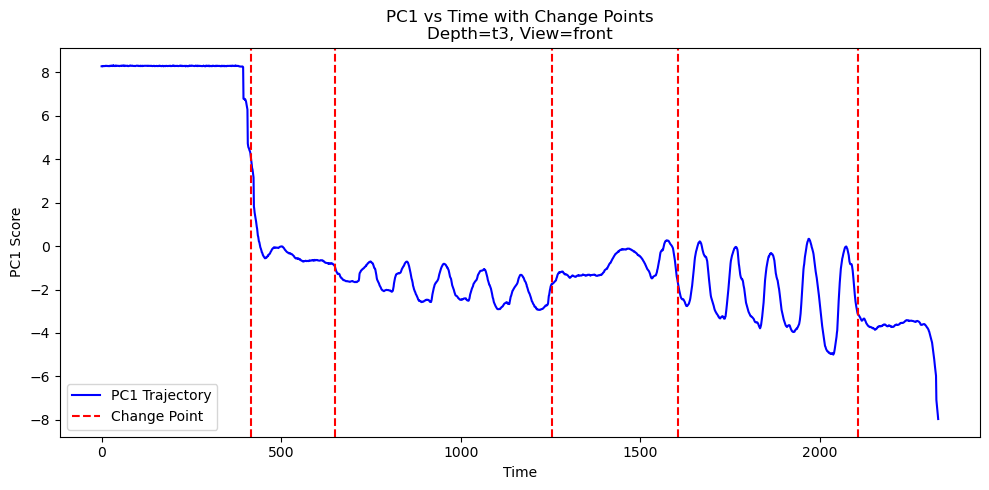

In [65]:
# New containers for start-segment PCA data
pca1_start_rows = []
pca2_start_rows = []
explained_start_rows = []
top5_start_pc1_rows = []
top5_start_pc2_rows = []

results_list2 = []

view_map = {"front": "f", "side": "s"}

for _, row in df_movements.iterrows():
    depth = row["dataset"]
    view = row["view"]

    # Skip if missing
    if pd.isna(depth) or pd.isna(view):
        continue

    # Map "front"/"side" to "f"/"s"
    view_letter = view_map.get(view.lower())

    if view_letter is None:
        print(f"Unrecognized view: {view}")
        continue

    base = f"{depth}{view_letter}"

    if base not in dataframes:
        print(f"Skipping {base} - not found in dataframes.")
        continue

    df_full = dataframes[base]
    


    # Get starting segment: from 0 to first change point of armEF so it only includes handOC and armPS
    change_points = row['arm_EF']  
    if not change_points or len(change_points) == 0:
        continue  # Skip if no change points
    
    # get the segment for only HOC and HPS
    first_cp = int(change_points[0])
    df_segment = df_full.iloc[:first_cp]

    # Trim initial zeros like before
    df_trimmed = trim_initial_zeros(df_segment)

    # Run PCA on start segment
    X_pca, explained_ratio, explained_raw, components = run_PCA(df_segment, None, base, "start")

    # 
    used_columns = df_segment.loc[:, ~df_segment.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    # X_pca shape: (n_samples, 2)
    pc1_scores = X_pca[:, 0]
    pc2_scores = X_pca[:, 1]
    t = np.arange(len(pc1_scores))

    # Now stack them for ruptures
    signal = np.column_stack((pc1_scores, pc2_scores))

    # Run ruptures (as you already do)
    algo = rpt.Pelt(model='rbf').fit(signal)
    change_points = algo.predict(pen=penalty_value)

    # Plot 3D trajectory with change points
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    
    plt.figure(figsize=(10, 5))

    # Plot PC1 scores over time
    plt.plot(t, pc1_scores, color='blue', label='PC1 Trajectory')

    # Mark change points with vertical dashed lines
    for cp in change_points[:-1]:  # Skip last point if it’s at the end
        plt.axvline(x=cp, color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")

    plt.xlabel('Time')
    plt.ylabel('PC1 Score')
    plt.title(f'PC1 vs Time with Change Points\nDepth={depth}, View={view_type}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    pc1 = components[0]
    pc2 = components[1]

    # Build PCA1 row
    row_pc1 = {"depth": depth, "view": view_letter, "component": "PC1"}
    row_pc2 = {"depth": depth, "view": view_letter, "component": "PC2"}
    
    for feat, w1, w2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = w1
        row_pc2[feat] = w2

    pca1_start_rows.append(row_pc1)
    pca2_start_rows.append(row_pc2)

    explained_start_rows.append({
        "depth": depth,
        "view": view_letter,
        "PC1_var": explained_ratio[0],
        "PC2_var": explained_ratio[1]
    })

    # Top 5 for PC1
    contributions = list(zip(final_cols, pc1))
    contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    top5 = contributions[:5]

    top5_dict = {
        "depth": depth,
        "view": view,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_start_pc1_rows.append(top5_dict)


    # Top 5 for PC2
    contributions_pc2 = list(zip(final_cols, pc2))
    contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = contributions_pc2[:5]

    top5_dict_pc2 = {
        "depth": depth,
        "view": view,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_dict_pc2[f"feature_{idx+1}"] = feat
        top5_dict_pc2[f"weight_{idx+1}"] = weight
    top5_start_pc2_rows.append(top5_dict_pc2)

    # Create a dictionary for storing change point results
    dic_indices2 = {
        "depth": depth,
        "view": view,
        "component": "indices"
    }

    # Save the top features and their change points
    dic_indices2["change_points"] = change_points

    # Assuming you're collecting multiple such dictionaries into a list
    results_list2.append(dic_indices2)


# At the end: convert to dataframes
pca1_start_df = pd.DataFrame(pca1_start_rows)
pca2_start_df = pd.DataFrame(pca2_start_rows)
explained_start_df = pd.DataFrame(explained_start_rows)
top5_start_pc1_df = pd.DataFrame(top5_start_pc1_rows)
top5_start_pc2_df = pd.DataFrame(top5_start_pc2_rows)

df_indices2 = pd.DataFrame(results_list2)



In [63]:
top5_start_pc1_df

,depth,view,component,feature_1,weight_1,feature_2,weight_2,feature_3,weight_3,feature_4,weight_4,feature_5,weight_5
0,b1,front,PC1,MCP4.1,0.233352,MCP3.1,0.232727,fTip5.1,0.232519,MCP2.1,0.231346,fTip4.1,0.228615
1,c1,front,PC1,MCP4.1,0.240591,MCP5.1,0.240322,fTip5.1,0.240319,MCP3.1,0.239339,fTip4.1,0.238106
2,c2,front,PC1,MCP5.1,0.250023,MCP4.1,0.249263,MCP3.1,0.248969,fTip5.1,0.246944,MCP2.1,0.246848
3,c3,front,PC1,MCP5.1,0.236412,MCP4.1,0.236352,MCP3.1,0.235378,MCP2.1,0.234027,fTip5.1,0.233423
4,t3,front,PC1,MCP3.1,0.246393,MCP2.1,0.246038,MCP4.1,0.246005,fTip5.1,0.243965,fTip4.1,0.242870


In [66]:
df_indices2 

,depth,view,component,change_points
0,b1,front,indices,"[405, 530, 1420, 2215, 2375]"
1,c1,front,indices,"[480, 1510, 2105, 2355]"
2,c2,front,indices,"[375, 520, 1155, 1390, 2255]"
3,c3,front,indices,"[315, 540, 625, 1485, 1550, 2285]"
4,t3,front,indices,"[415, 650, 1255, 1605, 2105, 2330]"


## Segment

[405, 530, 1420, 2215, 2375]
[410, 2375, 3235, 3295, 3515]


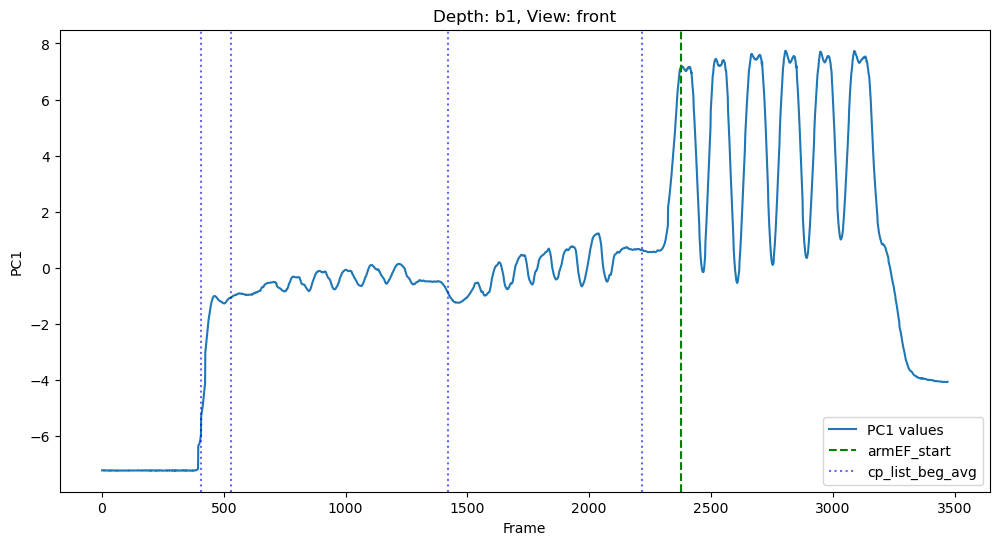

[480, 1510, 2105, 2355]
[480, 1555, 2355, 3245, 3640]


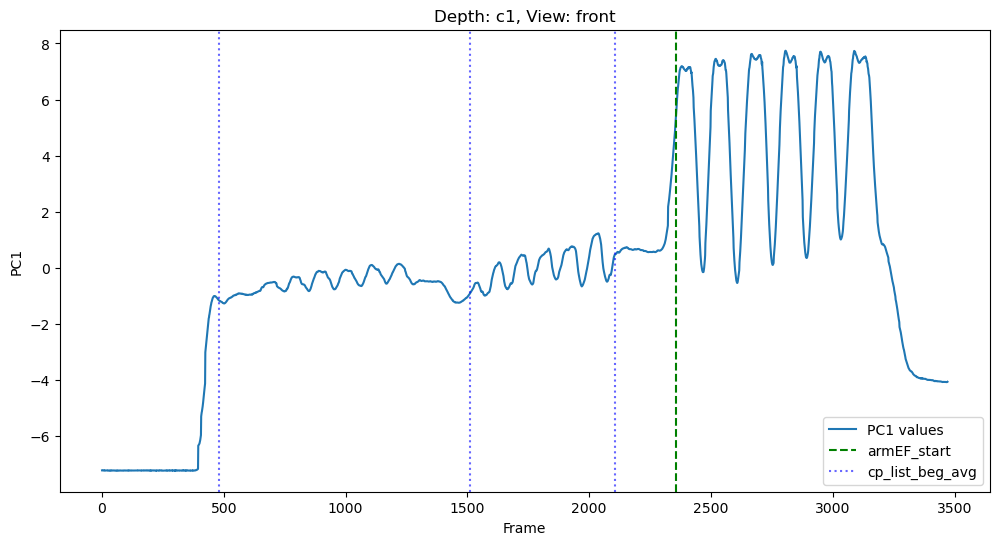

[375, 520, 1155, 1390, 2255]
[380, 2255, 3240, 3438]


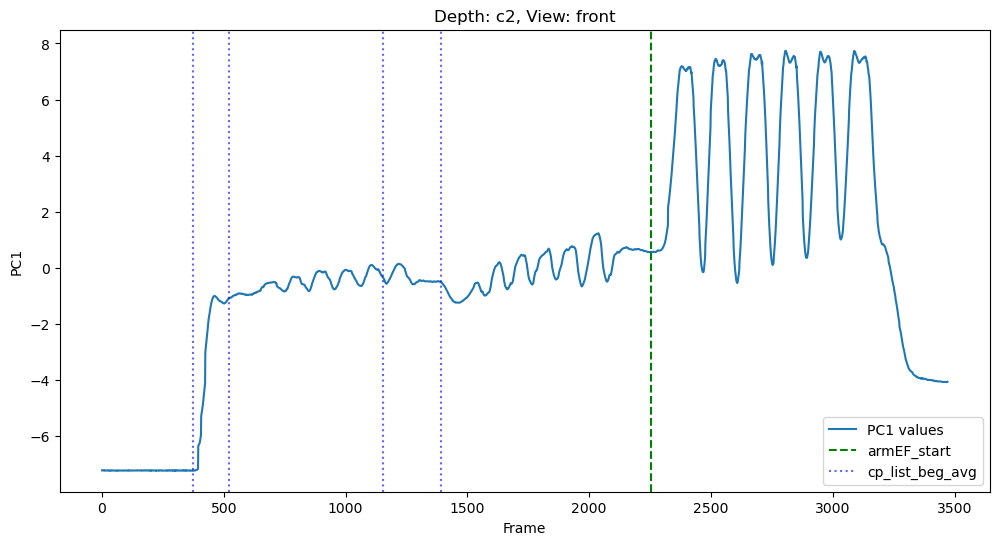

[315, 540, 625, 1485, 1550, 2285]
[320, 1545, 2285, 3175, 3285, 3517]


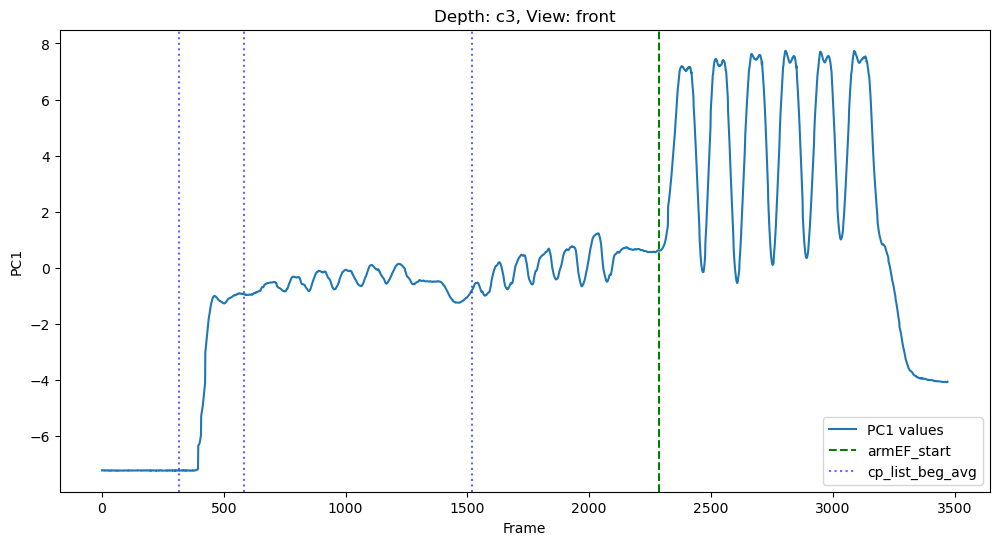

[415, 650, 1255, 1605, 2105, 2330]
[425, 1690, 2330, 3175, 3275, 3472]
infirst part


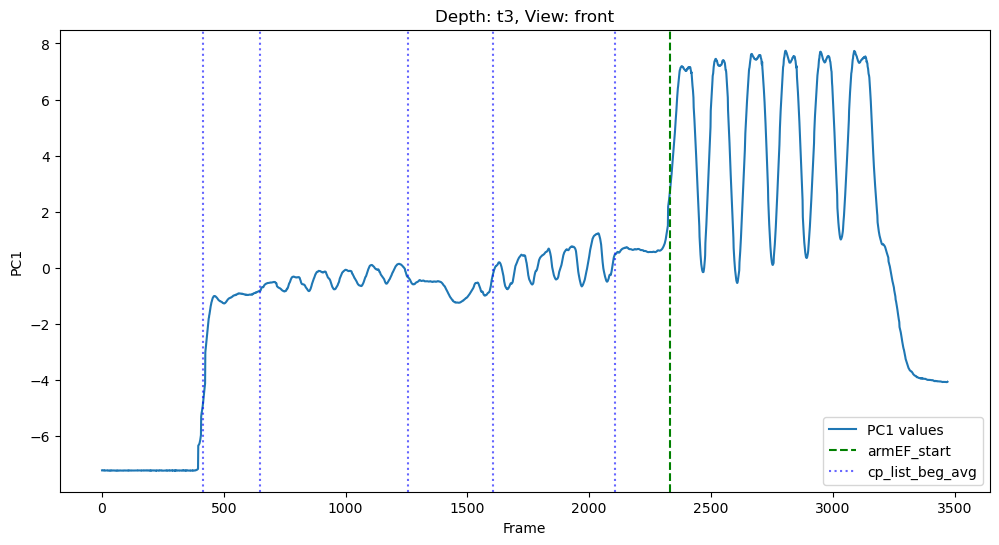

In [69]:
def average_close_points(points, threshold=100):
    """Average points that are within threshold of each other."""
    points = sorted(points)
    averaged = []
    cluster = [points[0]]
    for p in points[1:]:
        if p - cluster[-1] <= threshold:
            cluster.append(p)
        else:
            averaged.append(int(np.mean(cluster)))
            cluster = [p]
    averaged.append(int(np.mean(cluster)))
    return averaged

for idx, (depth, view) in enumerate(zip(df_movements['dataset'], df_movements['view'])):

    # skipping if the depth is not complete for trial
    if depth in skip_trails:
        continue
    
    armEF_start = df_movements.iloc[idx]['arm_EF'][0]  # First value of the tuple

    
    # Get cp lists from df_indices2 and df_indices (or wherever cp_list_all is)
    cp_list_beg = df_indices2.loc[
        (df_indices2['depth'] == depth) & (df_indices2['view'] == view), 'change_points'
    ].values
    if len(cp_list_beg) == 0:
        continue
    cp_list_beg = cp_list_beg[0]  # assuming it's a list stored in a cell

    print(cp_list_beg)
    
    cp_list_all = df_indices.loc[
        (df_indices['depth'] == depth) & (df_indices['view'] == view), 'change_points'
    ].values
    if len(cp_list_all) == 0:
        continue
    cp_list_all = cp_list_all[0]  # assuming list stored in cell

    print(cp_list_all)
    
    # Remove points >= armEF_start
    cp_list_beg_filtered = [pt for pt in cp_list_beg if pt < armEF_start]
    cp_list_all_filtered = [pt for pt in cp_list_all if pt < armEF_start]
    
    # Average points within 100 in cp_list_beg
    cp_list_beg_avg = average_close_points(cp_list_beg_filtered, threshold=100)

    # Find the row index in df_movements for the current depth and view
    row_idx = df_movements[
        (df_movements['dataset'] == depth) & 
        (df_movements['view'] == view)
    ].index

    if not row_idx.empty:
            row_idx = row_idx[0]  # Get the actual index value

            # abiity to tune specifically for earlier trials because there is more variability
            if 't' in depth:
                print('infirst part')
                if len(cp_list_beg_avg) <= 2:
                    print(' in second part')
                    df_movements.at[row_idx, 'hand_OC'] = (0, cp_list_beg_avg[0])
                    df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[0], armEF_start)
                elif cp_list_beg_avg[0] < 550:
                    if cp_list_beg_avg[1] < 550:
                        df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[1], cp_list_beg_avg[2])
                        df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[2], armEF_start)
                    else:
                    
                        # Update hand_OC and hand_PS columns directly
                        df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[0], cp_list_beg_avg[1])
                        df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[1], armEF_start)
                else:
                    df_movements.at[row_idx, 'hand_OC'] = (0, cp_list_beg_avg[0])
                    df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[0], armEF_start)


            elif cp_list_beg_avg[0] < 250:
                # Update hand_OC and hand_PS columns directly
                df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[0], cp_list_beg_avg[1])
                df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[1], armEF_start)
            else:
                df_movements.at[row_idx, 'hand_OC'] = (0, cp_list_beg_avg[0])
                df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[0], armEF_start)

    else:
        print(f"Row not found for dataset={depth}, view={view}")



    
    # Find common points between cp_list_beg_avg and cp_list_all_filtered within 100 units
    common_points = []
    for pt1 in cp_list_beg_avg:
        for pt2 in cp_list_all_filtered:
            if abs(pt1 - pt2) <= 100:
                common_points.append(int((pt1 + pt2) / 2))
                break
                
    common_points = sorted(set(common_points))
    
    # Get your dataframe with top PC1 feature for this depth & view
    df_key = depth + ('f' if view == 'front' else 's')
    if df_key not in dataframes:
        print(f"Missing df for {df_key}")
        continue
    df = dataframes[df_key]
    
    x = pca1_df.loc[some_row, 'values'] 
    t = np.arange(len(x))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(t, x, label=f"{'PC1'} values")
    
    # Plot armEF_start as vertical line
    plt.axvline(armEF_start, color='green', linestyle='--', label='armEF_start')
    
    # Plot change points
    for cp in cp_list_beg_avg:
        plt.axvline(cp, color='blue', linestyle=':', alpha=0.6, label='cp_list_beg_avg' if cp == cp_list_beg_avg[0] else "")
    '''
    for cp in cp_list_all_filtered:
        plt.axvline(cp, color='orange', linestyle=':', alpha=0.6, label='cp_list_all_filtered' if cp == cp_list_all_filtered[0] else "")
    for cp in common_points:
        plt.axvline(cp, color='red', linestyle='-', linewidth=2, label='common_points' if cp == common_points[0] else "")

    '''
    
    plt.title(f"Depth: {depth}, View: {view}")
    plt.xlabel('Frame')
    plt.ylabel('PC1')
    plt.legend()
    plt.show()


In [127]:
df_movements

,dataset,view,arm_EF,hand_OC,hand_PS
0,b1,front,"(715, 1298)","(0, 280)","(280, 715)"
1,b1,side,"(720, 1291)","(0, 350)","(350, 720)"
2,b2,front,"(845, 1361)","(135, 535)","(535, 845)"
3,b2,side,"(845, 1364)","(135, 525)","(525, 845)"
4,b3,front,"(615, 1158)","(0, 310)","(310, 615)"
5,b3,side,"(620, 1177)","(0, 310)","(310, 620)"
6,c1,front,"(1195, 1777)","(0, 475)","(475, 1195)"
7,c1,side,"(1200, 1751)","(0, 510)","(510, 1200)"
8,c2,front,"(1260, 1842)","(210, 640)","(640, 1260)"
9,c2,side,"(1260, 1839)","(232, 650)","(650, 1260)"


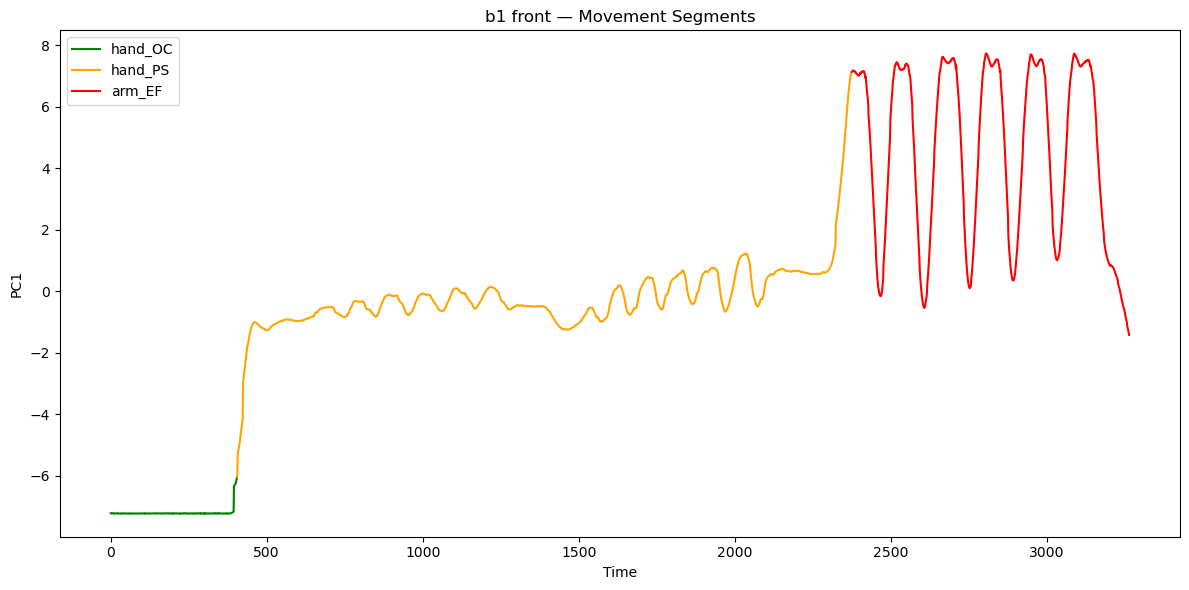

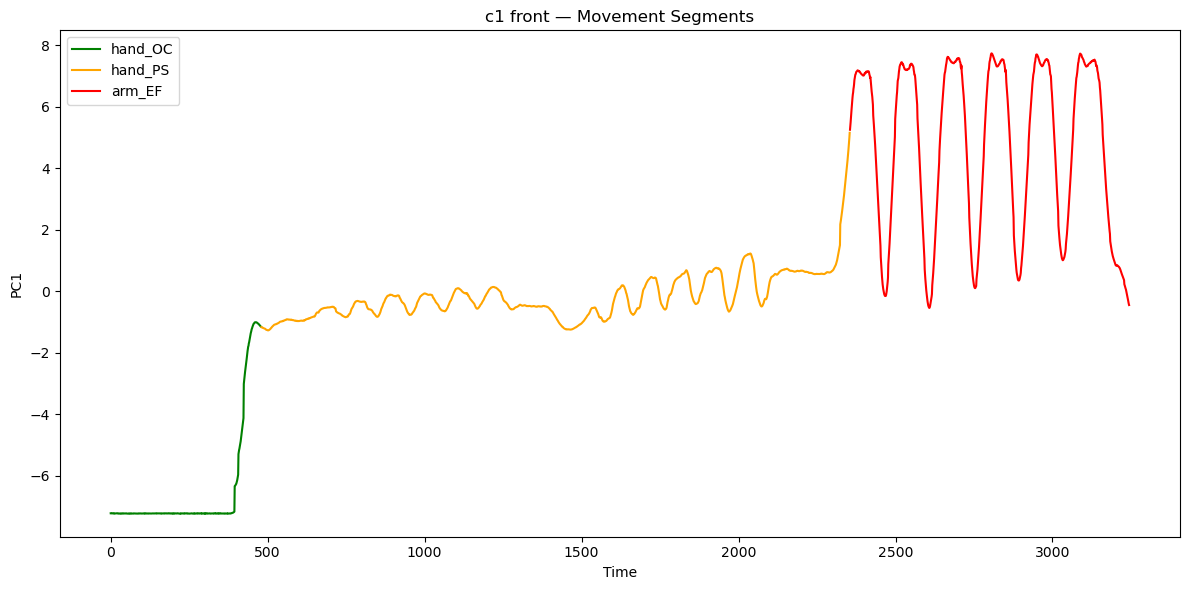

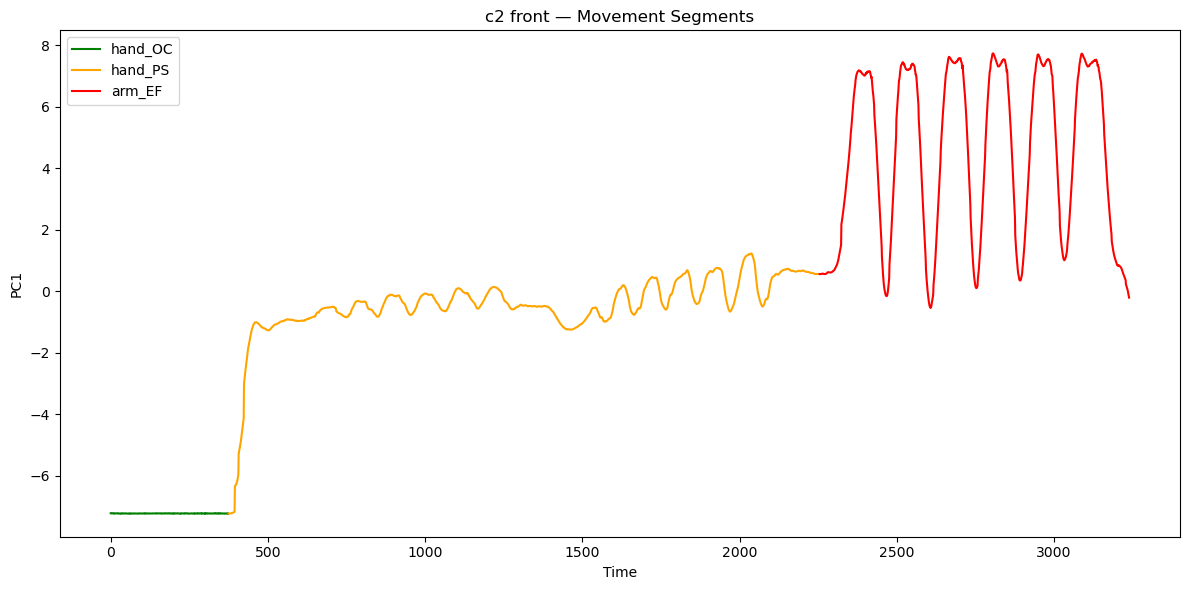

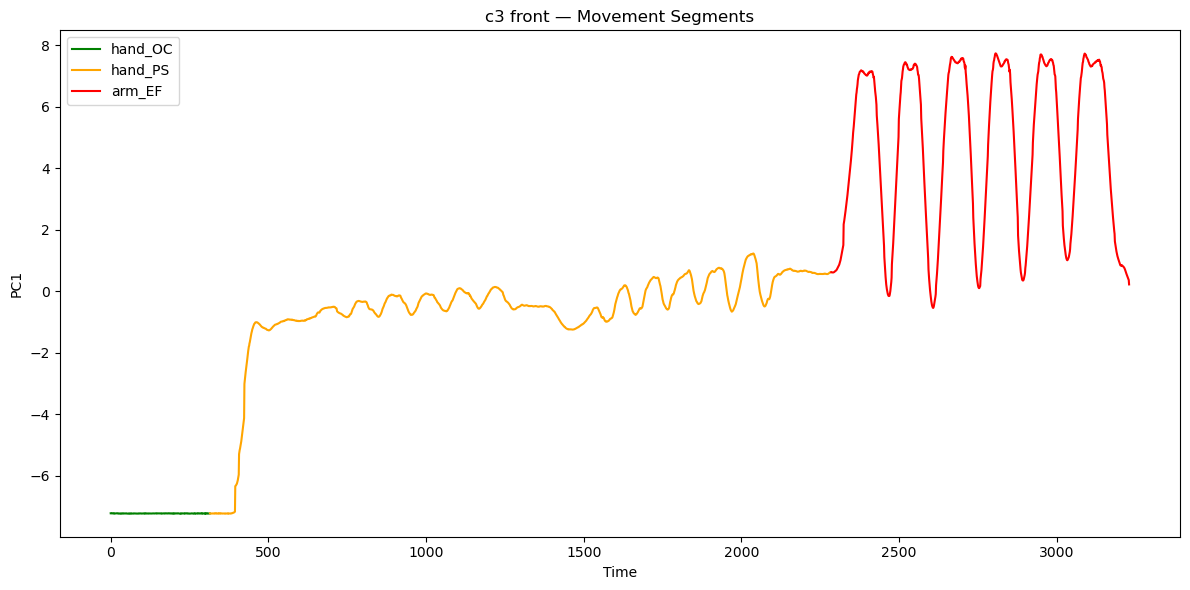

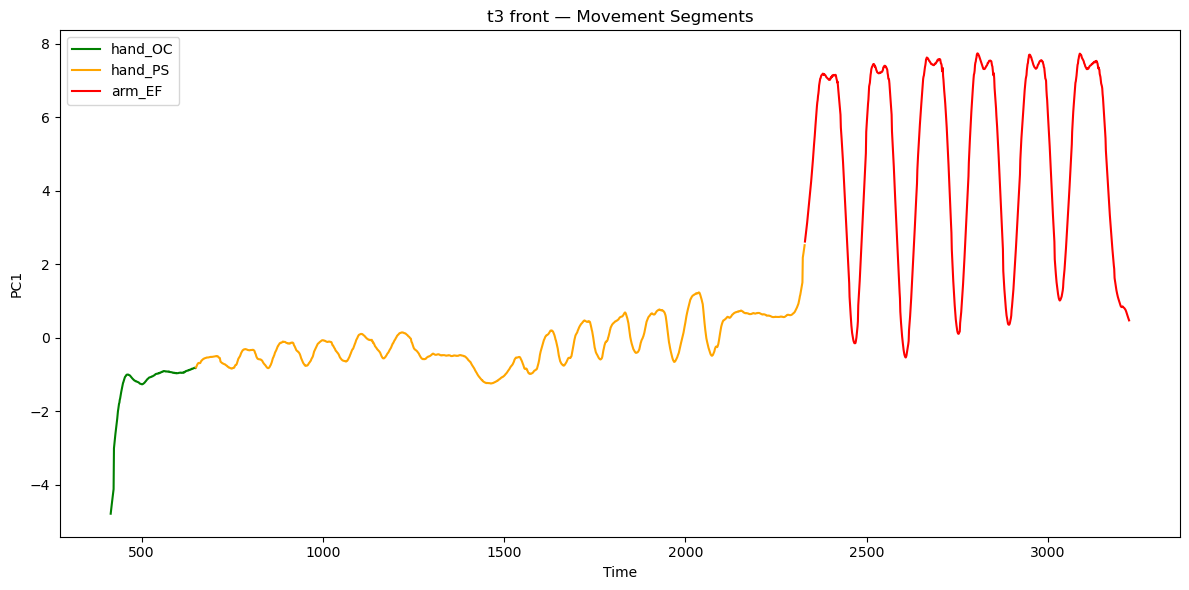

In [70]:
# Example colors for the movements
movement_colors = {
    'hand_OC': 'green',
    'hand_PS': 'orange',
    'arm_EF': 'red'
}

for idx, row in df_movements.iterrows():
    dataset = row['dataset']
    view = row['view']

    # Build dataframe key like before (e.g., 'b1f' for b1 front)
    df_key = dataset + ('f' if view == 'front' else 's')

    if df_key not in dataframes:
        print(f"Skipping {df_key} — data not found.")
        continue

    df = dataframes[df_key]
    
    # Extract x and t data
    x = pca1_df.loc[some_row, 'values']
    t = np.arange(len(x))

    # Get segment indices
    armEF_start, armEF_end = row['arm_EF']
    handOC_start, handOC_end = row['hand_OC']
    handPS_start, handPS_end = row['hand_PS']

    plt.figure(figsize=(12, 6))
    
    # Plot hand_OC segment
    plt.plot(t[handOC_start:handOC_end], x[handOC_start:handOC_end],
             color=movement_colors['hand_OC'], label='hand_OC')

    # Plot hand_PS segment
    plt.plot(t[handPS_start:handPS_end], x[handPS_start:handPS_end],
             color=movement_colors['hand_PS'], label='hand_PS')

    # Plot arm_EF segment
    plt.plot(t[armEF_start:armEF_end], x[armEF_start:armEF_end],
             color=movement_colors['arm_EF'], label='arm_EF')

    plt.title(f"{dataset} {view} — Movement Segments")
    plt.xlabel("Time")
    plt.ylabel("PC1")
    plt.legend()
    plt.tight_layout()
    plt.show()


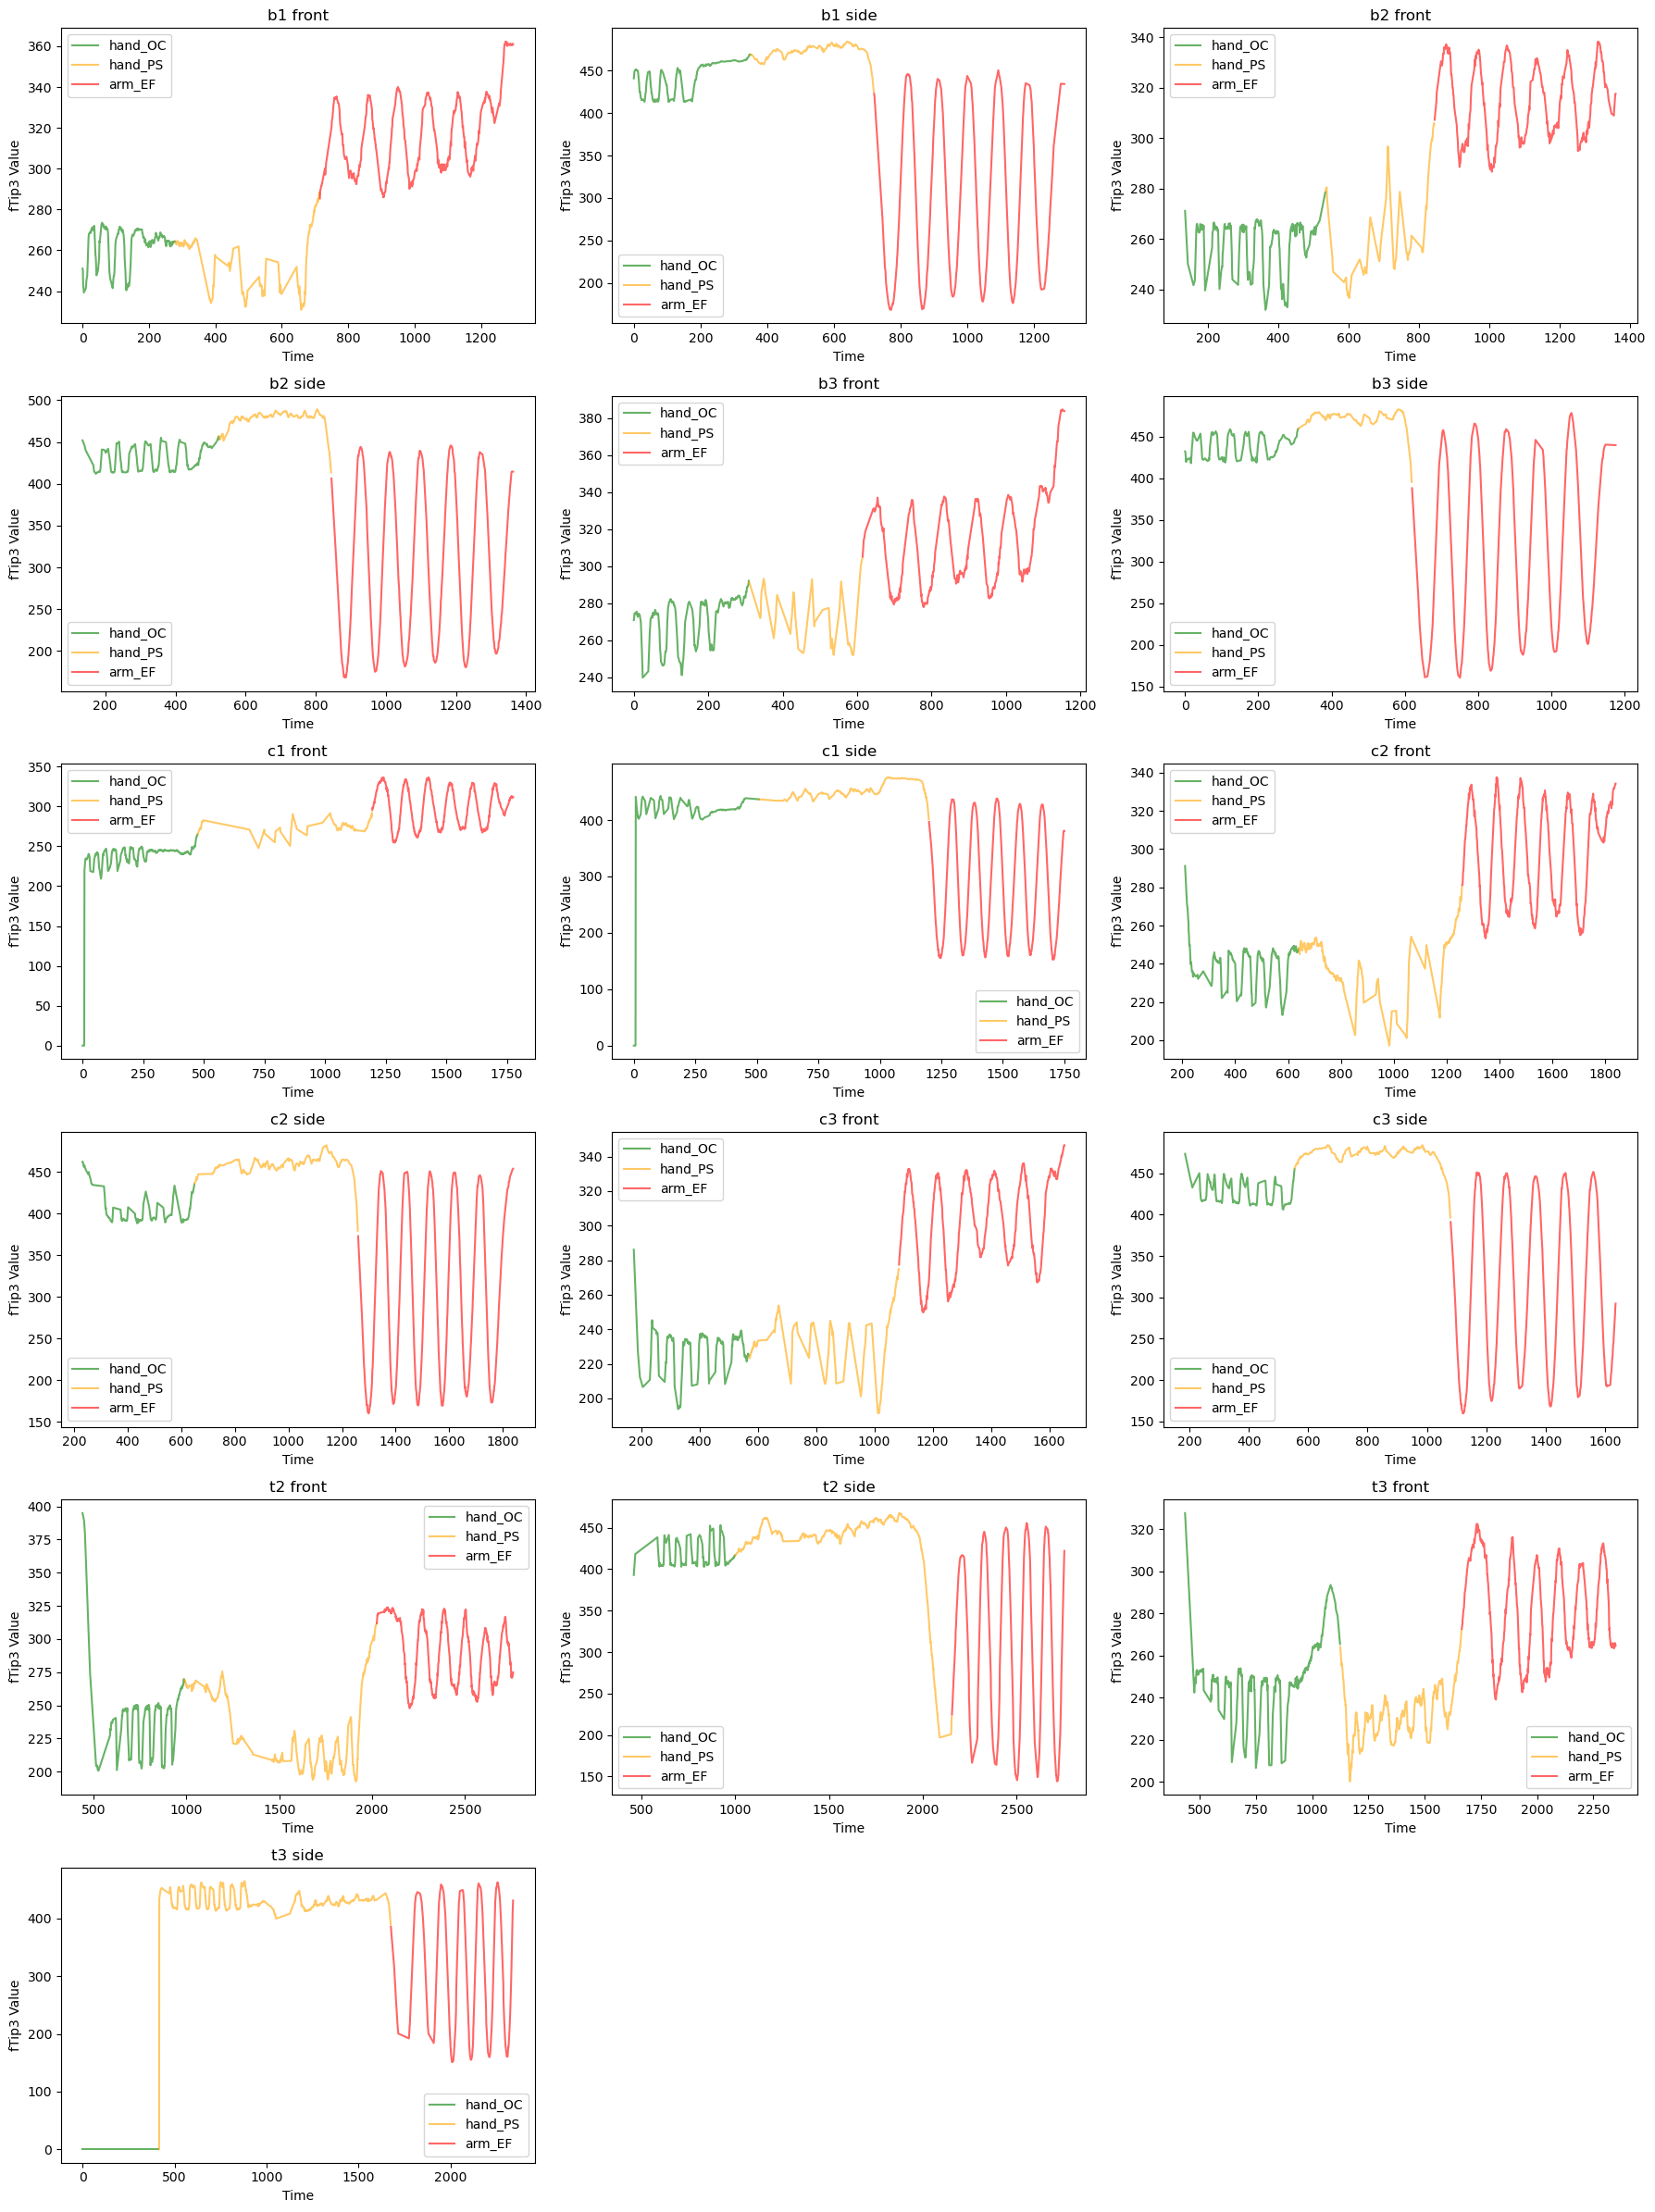

In [ ]:
# Number of plots = number of rows in df_movements
num_plots = len(df_movements)

# Decide layout (e.g., 3 columns)
cols = 3
rows = (num_plots + cols - 1) // cols  # ceiling division

# Create subplots grid
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), squeeze=False)

# Flatten axes for easy iteration
axes_flat = axes.flatten()

movement_colors = {
    'hand_OC': 'green',
    'hand_PS': 'orange',
    'arm_EF': 'red'
}

for idx, (row, ax) in enumerate(zip(df_movements.itertuples(), axes_flat)):
    dataset = row.dataset
    view = row.view

    df_key = dataset + ('f' if view == 'front' else 's')

    if df_key not in dataframes:
        print(f"Skipping {df_key} — data not found.")
        ax.axis('off')  # Hide empty subplot
        continue

    df = dataframes[df_key]

    x = df[top_feature_pc1].to_numpy()
    t = np.arange(len(x))

    armEF_start, armEF_end = row.arm_EF
    handOC_start, handOC_end = row.hand_OC
    handPS_start, handPS_end = row.hand_PS

    # Plot segments on the subplot ax
    ax.plot(t[handOC_start:handOC_end], x[handOC_start:handOC_end],
            color=movement_colors['hand_OC'], alpha=0.6, label='hand_OC')

    ax.plot(t[handPS_start:handPS_end], x[handPS_start:handPS_end],
            color=movement_colors['hand_PS'], alpha=0.6, label='hand_PS')

    ax.plot(t[armEF_start:armEF_end], x[armEF_start:armEF_end],
            color=movement_colors['arm_EF'], alpha=0.6, label='arm_EF')

    ax.set_title(f"{dataset} {view}")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{top_feature_pc1} Value")
    ax.legend()

# Hide any unused subplots if num_plots is less than rows*cols
for j in range(num_plots, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()


## Getting peaks and troughs

In [326]:
df_movements

,dataset,view,arm_EF,hand_OC,hand_PS
0,b1,front,"(715, 1298)","(0, 280)","(280, 715)"
1,b1,side,"(720, 1291)","(0, 350)","(350, 720)"
2,b2,front,"(845, 1361)","(135, 535)","(535, 845)"
3,b2,side,"(845, 1364)","(135, 525)","(525, 845)"
4,b3,front,"(615, 1158)","(0, 310)","(310, 615)"
5,b3,side,"(620, 1177)","(0, 310)","(310, 620)"
6,c1,front,"(1195, 1777)","(0, 475)","(475, 1195)"
7,c1,side,"(1200, 1751)","(0, 510)","(510, 1200)"
8,c2,front,"(1260, 1842)","(210, 640)","(640, 1260)"
9,c2,side,"(1260, 1839)","(232, 650)","(650, 1260)"


In [418]:
# OPTIONAL: Drop existing computed columns if re-running (can get rid of this once pipeline is set)
cols_to_remove = [col for col in df_movements.columns if 'peaks' in col or 'troughs' in col or 'euclidean_dis' in col or 'arm_EF_data' in col]
df_movements = df_movements.drop(columns=cols_to_remove, errors='ignore')

# Recompute
results_df = df_movements.apply(compute_peaks_troughs, axis=1)
df_movements = pd.concat([df_movements, results_df], axis=1)


df_movements

Raw peaks: [ 63 158 320], dtype: int64
Raw troughs: [ 95 293], dtype: int64
Raw peaks: [ 38  87 133 176 215 252], dtype: int64
Raw troughs: [  9  62 107 151 194 233 270], dtype: int64
Raw peaks: [ 35  84 111 162 205 253], dtype: int64
Raw troughs: [ 12  57  98 136 181 226 275], dtype: int64
Raw peaks: [ 82 199 267 332 399 465 539 611 697], dtype: int64
Raw troughs: [172 237 292 378 449 507], dtype: int64
Raw peaks: [ 62 162 236 301 366 429 491], dtype: int64
Raw troughs: [126 187 276 336 399 459 535], dtype: int64
Raw peaks: [ 95 159 221 282 344 413], dtype: int64
Raw troughs: [116 180 255 319 366 480], dtype: int64
Raw peaks: [223 357 474 527 593 667 742 821 892], dtype: int64
Raw troughs: [338 428 503 618 699 762 845 929], dtype: int64
Raw peaks: [ 54 130 193 278 358 441], dtype: int64
Raw troughs: [ 30  93 157 235 314 385 500], dtype: int64


,dataset,view,arm_EF,hand_OC,hand_PS,hand_OC_peaks,hand_OC_troughs,hand_OC_euclidean_dis,hand_PS_peaks,hand_PS_troughs,hand_PS_euclidean_dis,arm_EF_peaks,arm_EF_troughs,arm_EF_data
0,b1,front,"(715, 1298)","(0, 280)","(280, 715)","[27, 65, 112, 182]","[44, 89, 136]","[-65.18766113284943, -65.53525681439089, -66.1...","[343, 438, 600]","[375, 573]","[36.66600328421755, 36.67343900924146, 36.6881...","[764, 863, 951, 1040, 1132]","[822, 906, 990, 1087, 1168]","[290.4501494021665, 290.5814338013699, 290.837..."
1,b1,side,"(720, 1291)","(0, 350)","(350, 720)",None,None,None,None,None,None,None,None,None
2,b2,front,"(845, 1361)","(135, 535)","(535, 845)","[177, 221, 256, 299, 345, 393, 492]","[148, 197, 236, 278, 322, 366, 421]","[-96.9870368254948, -97.27001110237158, -97.81...","[573, 622, 668, 711, 750, 787]","[544, 597, 642, 686, 729, 768, 805]","[6.500656191062099, 6.043774051949722, 5.18539...","[878, 968, 1052, 1136, 1225, 1313]","[919, 1007, 1094, 1176, 1259]","[312.6223591087107, 312.860199930064, 313.3239..."
3,b2,side,"(845, 1364)","(135, 525)","(525, 845)",None,None,None,None,None,None,None,None,None
4,b3,front,"(615, 1158)","(0, 310)","(310, 615)","[54, 103, 150, 189, 240]","[31, 79, 128, 169, 211]","[-33.6298884986964, -33.61118822764665, -33.57...","[345, 394, 421, 472, 515, 563]","[322, 367, 408, 446, 491, 536, 585]","[24.66523856029607, 23.645622000552272, 21.684...","[654, 746, 834, 922, 1008, 1098]","[700, 782, 869, 958, 1046]","[312.94021181379185, 313.1502870996322, 313.55..."
5,b3,side,"(620, 1177)","(0, 310)","(310, 620)",None,None,None,None,None,None,None,None,None
6,c1,front,"(1195, 1777)","(0, 475)","(475, 1195)","[21, 55, 91, 129, 163, 203, 238, 446]","[38, 74, 110, 147, 186, 222, 258]","[-301.7386333759886, -297.2680478811725, -288....","[557, 674, 742, 807, 874, 940, 1014, 1086, 1172]","[647, 712, 767, 853, 924, 982]","[36.89395506526608, 36.91124486470153, 36.9469...","[1238, 1333, 1425, 1517, 1609, 1701]","[1288, 1380, 1474, 1564, 1654, 1740]","[299.757870944247, 299.9450038940606, 300.3139..."
7,c1,side,"(1200, 1751)","(0, 510)","(510, 1200)",None,None,None,None,None,None,None,None,None
8,c2,front,"(1260, 1842)","(210, 640)","(640, 1260)","[331, 390, 441, 500, 554]","[281, 360, 414, 470, 521, 583]","[-22.058473418562443, -22.378717637358587, -23...","[702, 802, 876, 941, 1006, 1069, 1131]","[766, 827, 916, 976, 1039, 1099, 1175]","[32.387664209113716, 32.38902607481647, 32.390...","[1293, 1392, 1482, 1571, 1663, 1756]","[1348, 1435, 1533, 1620, 1710, 1791]","[287.8070065364252, 288.16960462191844, 288.87..."
9,c2,side,"(1260, 1839)","(232, 650)","(650, 1260)",None,None,None,None,None,None,None,None,None


## Viewing peaks and troughs

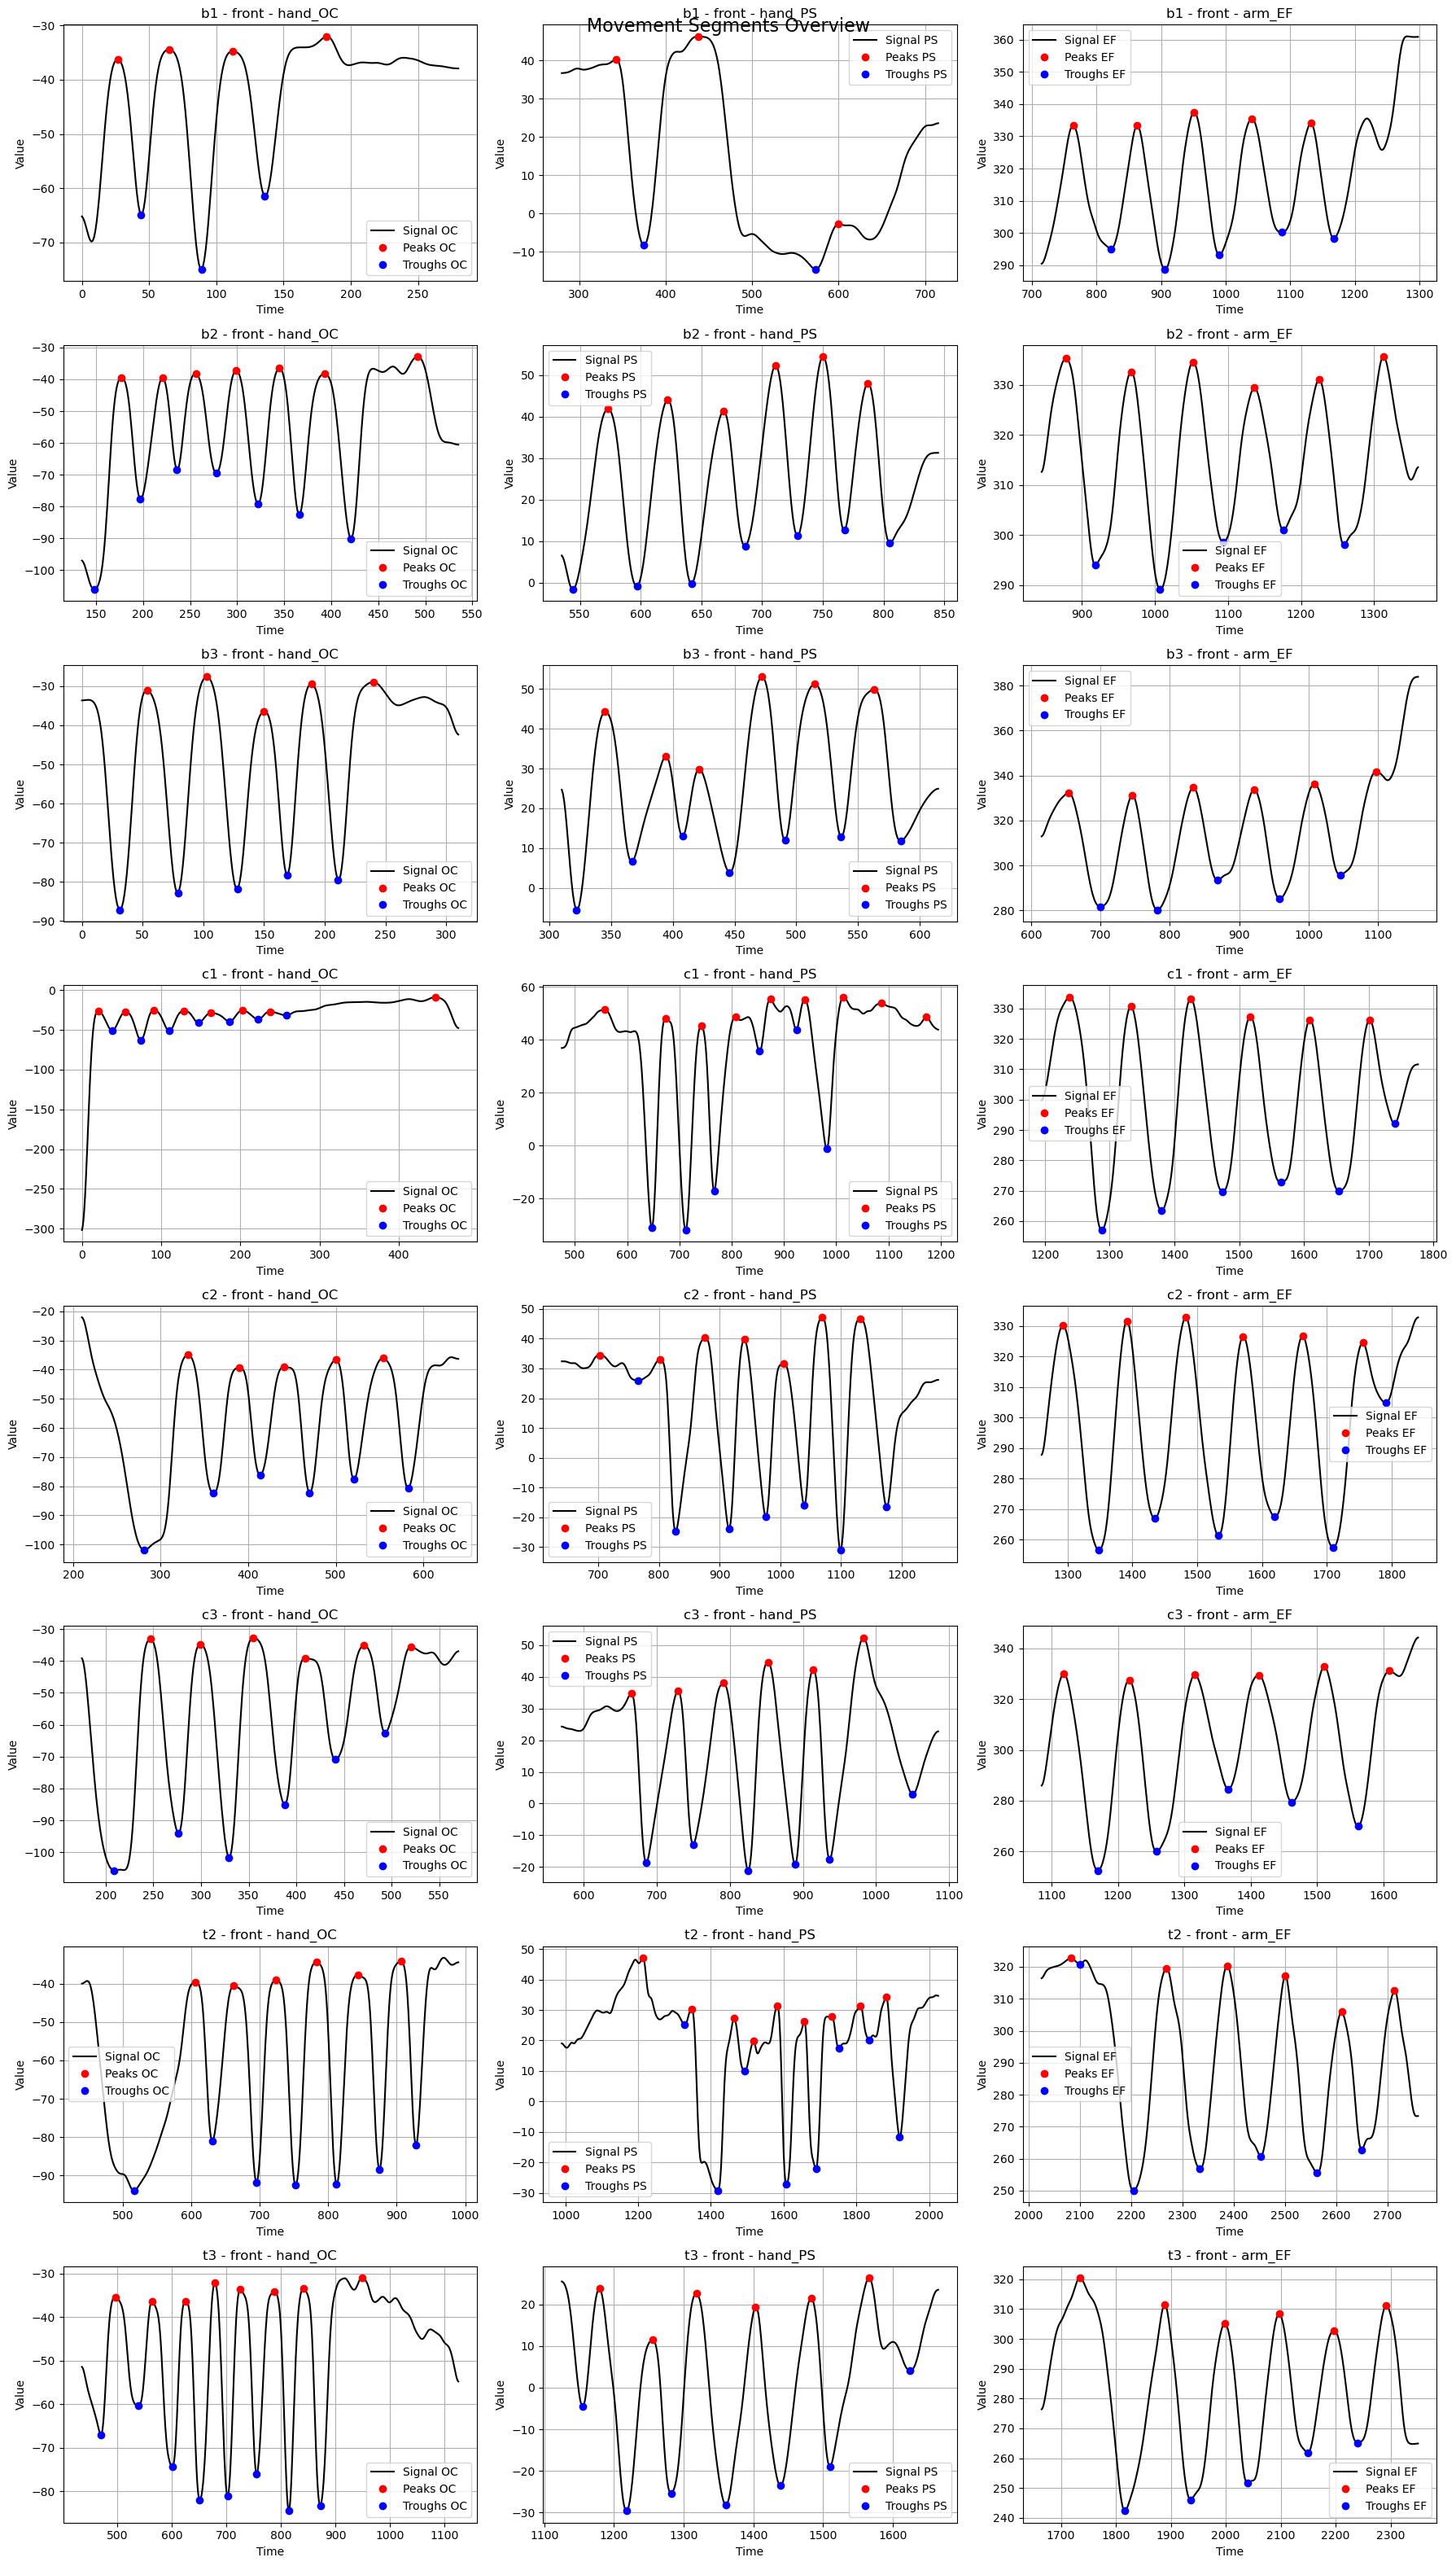

In [419]:
def plot_segment(ax, t, data, peaks=None, troughs=None, label_suffix=""):
    ax.plot(t, data, label=f'Signal {label_suffix}', color='black')

    peaks = np.atleast_1d(peaks)
    if peaks.size > 0 and not np.all(pd.isna(peaks)):
        ax.plot(peaks, np.interp(peaks, t, data), 'ro', label=f'Peaks {label_suffix}')

    troughs = np.atleast_1d(troughs)
    if troughs.size > 0 and not np.all(pd.isna(troughs)):
        ax.plot(troughs, np.interp(troughs, t, data), 'bo', label=f'Troughs {label_suffix}')

num_plots = 0  # will count how many subplots we actually need

# Count how many subplots we'll create
for _, row in df_movements.iterrows():
    if row['hand_OC'] is not None:
        num_plots += 1
    elif row['view'] == 'front':
        if row['hand_PS'] is not None:
            num_plots += 1
        if row['arm_EF'] is not None:
            num_plots += 1

cols = 3
rows = ((num_plots + cols - 1) // cols) + 2  # add an extra row buffer

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

plot_idx = 0  # index for axes

for idx, row in df_movements.iterrows():

    if row['hand_OC_euclidean_dis'] is None or len(row['hand_OC_euclidean_dis']) == 0:
        continue

    depth = row['dataset']
    view = row['view']

    df_key = depth + ('f')
    df_data = dataframes.get(df_key)
    if df_data is None:
        print(f"Data not found for {df_key} — Skipping")
        continue

    
    ax = axes[plot_idx]
    plot_idx += 1

    start, end = row['hand_OC']
    segment = row['hand_OC_euclidean_dis']
    tOC = np.arange(len(segment)) + start

    plot_segment(ax, tOC, segment,
                    peaks=row.get('hand_OC_peaks'),
                    troughs=row.get('hand_OC_troughs'),
                    label_suffix='OC')

    ax.set_title(f"{depth} - front - hand_OC")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    # For front view, plot hand_PS and arm_EF on separate subplots if they exist

    if row['hand_PS'] is not None:
        ax = axes[plot_idx]
        plot_idx += 1

        start_ps, end_ps = row['hand_PS']
        segment = row['hand_PS_euclidean_dis']
        tPS = np.arange(len(segment)) + start_ps

        plot_segment(ax, tPS, segment,
                        peaks=row.get('hand_PS_peaks'),
                        troughs=row.get('hand_PS_troughs'),
                        label_suffix='PS')

        ax.set_title(f"{depth} - front - hand_PS")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

    if row['arm_EF'] is not None:
        ax = axes[plot_idx]
        plot_idx += 1

        start_ef, end_ef = row['arm_EF']
        segment = row['arm_EF_data']
        tEF = np.arange(len(segment)) + start_ef

        plot_segment(ax, tEF, segment,
                        peaks=row.get('arm_EF_peaks'),
                        troughs=row.get('arm_EF_troughs'),
                        label_suffix='EF')

        ax.set_title(f"{depth} - front - arm_EF")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

# Remove unused axes
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Movement Segments Overview", fontsize=16)
plt.subplots_adjust(top=0.5)
plt.tight_layout()
plt.show()


In [284]:
df_movements

,dataset,view,arm_EF,hand_OC,hand_PS,hand_OC_peaks,hand_OC_troughs,hand_OC_euclidean_dis,hand_PS_peaks,hand_PS_troughs,arm_EF_peaks,arm_EF_troughs
0,b1,front,"(715, 1298)","(0, 280)","(280, 715)",None,None,None,None,None,None,None
1,b1,side,"(720, 1291)","(0, 350)","(350, 720)",None,None,None,None,None,None,None
2,b2,front,"(845, 1361)","(135, 535)","(535, 845)",None,None,None,None,None,None,None
3,b2,side,"(845, 1364)","(135, 525)","(525, 845)",None,None,None,None,None,None,None
4,b3,front,"(615, 1158)","(0, 310)","(310, 615)",None,None,None,None,None,None,None
5,b3,side,"(620, 1177)","(0, 310)","(310, 620)",None,None,None,None,None,None,None
6,c1,front,"(1195, 1777)","(0, 475)","(475, 1195)",None,None,None,None,None,None,None
7,c1,side,"(1200, 1751)","(0, 510)","(510, 1200)",None,None,None,None,None,None,None
8,c2,front,"(1260, 1842)","(210, 640)","(640, 1260)",None,None,None,None,None,None,None
9,c2,side,"(1260, 1839)","(232, 650)","(650, 1260)",None,None,None,None,None,None,None


## Creating new df and exporting all different start and stops

In [357]:
def safe_concat(series):
    series = series.dropna()
    combined = []
    for item in series:
        if isinstance(item, list):
            combined.extend(item)
        elif isinstance(item, np.ndarray):
            combined.extend(item.tolist())
        elif np.isscalar(item):
            combined.append(item)
    return combined


export_rows = []  # Collect rows as dictionaries here

for depth in df_movements['dataset'].unique():
    subset = df_movements[df_movements['dataset'] == depth]

    hand_OC_peaks = safe_concat(subset['hand_OC_peaks'])
    hand_OC_troughs = safe_concat(subset['hand_OC_troughs'])
    hand_PS_peaks = safe_concat(subset['hand_PS_peaks'])
    hand_PS_troughs = safe_concat(subset['hand_PS_troughs'])
    arm_EF_peaks = safe_concat(subset['arm_EF_peaks'])
    
    # Concatenate troughs like others but also adding the change point
    arm_EF_troughs = safe_concat(subset['arm_EF_troughs'])

    # Get the first index from 'arm_EF' 
    first_arm_EF_entry = subset['arm_EF'].iloc[0]
    first_index = first_arm_EF_entry[0]

    # append it to troughs
    arm_EF_troughs = [first_index] + arm_EF_troughs


    export_rows.append({
        'dataset': depth,
        'hand_OC_peaks': hand_OC_peaks,
        'hand_OC_troughs': hand_OC_troughs,
        'hand_PS_peaks': hand_PS_peaks,
        'hand_PS_troughs': hand_PS_troughs,
        'arm_EF_peaks': arm_EF_peaks,
        'arm_EF_troughs': arm_EF_troughs
    })

# Build df_export from the list of rows
df_export = pd.DataFrame(export_rows)


In [358]:
df_export

,dataset,hand_OC_peaks,hand_OC_troughs,hand_PS_peaks,hand_PS_troughs,arm_EF_peaks,arm_EF_troughs
0,b1,"[27, 112]","[44, 89, 136]","[343, 600]",[],"[765, 860, 950, 1042, 1130]","[715, 825, 906, 1080, 1168]"
1,b2,"[221, 256, 345, 393, 492]","[197, 236, 421]","[622, 668]","[544, 597, 642, 686, 729, 768, 805]","[877, 970, 1050, 1136, 1223, 1311]","[845, 916, 1008, 1172, 1253, 1355]"
2,b3,[54],"[31, 79, 128, 211]","[345, 394, 563]","[322, 367, 446, 536, 585]","[655, 748, 834, 924, 1006]","[615, 699, 779, 866, 955, 1044]"
3,c1,"[21, 55, 91, 129, 163, 203]","[38, 74, 110, 147, 258]","[674, 807, 1014]","[712, 924, 982]","[1242, 1333, 1427, 1514, 1609, 1699]","[1195, 1288, 1382, 1478, 1559, 1649, 1741]"
4,c2,"[390, 441, 500]","[281, 360, 470, 521]","[941, 1006, 1069]","[827, 916, 976, 1099]","[1295, 1390, 1481, 1573, 1660]","[1260, 1348, 1438, 1536, 1617, 1708, 1795]"
5,c3,"[247, 299, 355, 409, 520]","[209, 276, 329, 388, 441, 493]","[665, 729, 791, 852, 914, 983]","[686, 750, 825, 889, 936]","[1117, 1219, 1317, 1411, 1513]","[1085, 1168, 1253, 1364, 1459, 1559]"
6,t2,"[662, 906]","[631, 695, 752, 812, 875, 928]","[1213, 1347, 1583, 1657, 1732, 1811, 1882]","[1418, 1608, 1689, 1752, 1919]","[2083, 2269, 2388, 2504, 2609, 2717]","[2025, 2202, 2336, 2454, 2564, 2649]"
7,t3,"[564, 625, 725, 841]","[470, 601, 651, 755, 814, 872]","[1255, 1483, 1566]",[1282],"[1732, 1891, 1999, 2099, 2204, 2294]","[1665, 1817, 1934, 2038, 2152, 2243]"


In [359]:
# Assuming df_export already exists and has concatenated peaks/troughs per depth
movement_types = ['hand_OC', 'hand_PS', 'arm_EF']

# Dictionary to hold DataFrames for each depth
depth_dfs = {}

# Output folder
output_folder = 'exported_movements'
os.makedirs(output_folder, exist_ok=True)

for idx, row in df_export.iterrows():
    depth = row['dataset']
    movement_data = []

    for movetype in movement_types:
        peaks = row[f'{movetype}_peaks']
        troughs = row[f'{movetype}_troughs']

        # Skip if peaks or troughs length <= 1
        if len(peaks) <= 1 or len(troughs) <= 1:
            continue

        # Ensure equal length for pairing (truncate to shortest length)
        pair_count = min(len(peaks), len(troughs))

        for i in range(pair_count):
            if movetype == 'hand_PS':
                movement_data.append({
                    'dataset': depth,
                    'movetype': movetype,
                    'moveN': i + 1,
                    'BeginF': peaks[i],
                    'EndF': troughs[i]
                })
            else:
                movement_data.append({
                    'dataset': depth,
                    'movetype': movetype,
                    'moveN': i + 1,
                    'BeginF': troughs[i],
                    'EndF': peaks[i]
                })

    # Create DataFrame for this depth and add to dictionary
    depth_df = pd.DataFrame(movement_data)
    depth_dfs[depth] = depth_df

    # Export as CSV
    depth_df.to_csv(os.path.join(output_folder, f'{depth}_movements.csv'), index=False)

print(f"Exported {len(depth_dfs)} depth CSV files to folder: {output_folder}")


Exported 8 depth CSV files to folder: exported_movements


In [ ]:
# things to now calculate for each movement
    # amplitude
    # distance between peaks
    # lag? --> maybe reread those papers
    ### mean distance between each peak for each movement
    # peak width
    # speed
    # duration

### one paper did a box and whisker plot of all the period frames with the finger tapping and this showed a severity of a tremor score I think --> i wonder if we can do this or there is any relevance here?
### also from that one paper
# mean freq of actions
# coefficient of variation of the freq of actions (std/mean)
# average velocities between peaks and troughs
# coefficient of variation of the velocities between peaks and troughs
# mean amplitude of actions
# coefficient of variation of the amplitudes of actions 

##### can these then correlate with the MDS UDS ratings/scale?!?!!?